In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import itertools

import pandas as pd
import statsmodels.api as sm 

def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

def regress_error(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    output = list(result.params)
    output.extend(list(result.bse))
    return pd.Series(output, ["slope", "intercept", "slope_e", "intercept_e"])

sns.set(style="darkgrid", palette="Set2") 

# Mut day two

In [13]:
additive = {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met", "F": "none", "G": "B12", "H": "Zn"}
adf = pl.DataFrame(additive).transpose(include_header=True)
adf = adf.rename({"column": "Row", "column_0": "Additive"})

genotype_row = [["A", "B", "C", "D"], ["E", "F", "G", "H"]]
genotype_col = [["1", "2", "3", "4"], ["5", "6", "7", "8"], ["9", "10", "11", "12"]]

genotype_combinations = {"YkgM1": [0, 0], "YkgM2": [0, 1], "MetH": [0, 2], "Zur": [1, 0], "MetE": [1, 1], "MG1655": [1, 2]}

gdf = []

for genotype, idx in genotype_combinations.items():

    gdf.extend([[genotype, x+y] for x in genotype_row[idx[0]] for y in genotype_col[idx[1]]])

gdf

gdf = pl.DataFrame(gdf).transpose()
gdf = gdf.rename({"column_0": "Genotype", "column_1": "Well"})

df = pl.read_csv("growth_data/cyrus_mutant_020124.txt", separator="\t")
df = df.drop('T600')
df.head(3)

blank_df = pl.read_csv("growth_data/cyrus_mutant_blanks_020124.txt", separator="\t")
blank_df = blank_df.drop(['T600', 'Time']).mean().transpose(include_header=True)
blank_df = blank_df.rename({"column": "Well", "column_0": "Background_OD"})
blank_df.head(3)

shape: (3, 2)
┌──────┬───────────────┐
│ Well ┆ Background_OD │
│ ---  ┆ ---           │
│ str  ┆ f64           │
╞══════╪═══════════════╡
│ A1   ┆ 0.094238      │
│ A2   ┆ 0.137952      │
│ A3   ┆ 0.179333      │
└──────┴───────────────┘

In [14]:
# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(df['Time'].dt.hour().cast(pl.Int64) + df['Time'].dt.minute().cast(pl.Int64) / 60 + df['Time'].dt.second() / 3600)

# initial measurement
init_df = df.drop("Time")[0:100,:].min().transpose(include_header=True)
init_df = init_df.rename({"column": "Well", "column_0": "Initial_OD"})

# melt to experiments
mdf = df.melt(id_vars="Time", variable_name="Well", value_name="OD")
mdf = mdf.with_columns((mdf["Well"].str.slice(0,1)).alias("Row"))
mdf = mdf.with_columns((mdf["Well"].str.slice(1)).alias("Column"))

mdf = mdf.join(adf, on="Row")
mdf = mdf.join(gdf, on="Well")
mdf = mdf.join(blank_df, on="Well")
mdf = mdf.join(init_df, on="Well")

mdf = mdf.with_columns(((pl.col("Column").cast(pl.Int32)+3) % 4 + 1).alias("Replicate"))

mdf



shape: (66_240, 10)
┌───────────┬──────┬───────┬─────┬───┬──────────┬───────────────┬────────────┬───────────┐
│ Time      ┆ Well ┆ OD    ┆ Row ┆ … ┆ Genotype ┆ Background_OD ┆ Initial_OD ┆ Replicate │
│ ---       ┆ ---  ┆ ---   ┆ --- ┆   ┆ ---      ┆ ---           ┆ ---        ┆ ---       │
│ f64       ┆ str  ┆ f64   ┆ str ┆   ┆ str      ┆ f64           ┆ f64        ┆ i32       │
╞═══════════╪══════╪═══════╪═════╪═══╪══════════╪═══════════════╪════════════╪═══════════╡
│ 0.011111  ┆ A1   ┆ 0.171 ┆ A   ┆ … ┆ YkgM1    ┆ 0.094238      ┆ 0.166      ┆ 1         │
│ 0.036111  ┆ A1   ┆ 0.171 ┆ A   ┆ … ┆ YkgM1    ┆ 0.094238      ┆ 0.166      ┆ 1         │
│ 0.061111  ┆ A1   ┆ 0.169 ┆ A   ┆ … ┆ YkgM1    ┆ 0.094238      ┆ 0.166      ┆ 1         │
│ 0.086111  ┆ A1   ┆ 0.168 ┆ A   ┆ … ┆ YkgM1    ┆ 0.094238      ┆ 0.166      ┆ 1         │
│ 0.111111  ┆ A1   ┆ 0.169 ┆ A   ┆ … ┆ YkgM1    ┆ 0.094238      ┆ 0.166      ┆ 1         │
│ …         ┆ …    ┆ …     ┆ …   ┆ … ┆ …        ┆ …             ┆ …          ┆ …         │
│ 17.136111 ┆ H12  ┆ 1.153 ┆ H   ┆ … ┆ MG1655   ┆ 0.102143      ┆ 0.168      ┆ 4         │
│ 17.161111 ┆ H12  ┆ 1.152 ┆ H   ┆ … ┆ MG1655   ┆ 0.102143      ┆ 0.168      ┆ 4         │
│ 17.186111 ┆ H12  ┆ 1.152 ┆ H   ┆ … ┆ MG1655   ┆ 0.102143      ┆ 0.168      ┆ 4         │
│ 17.211111 ┆ H12  ┆ 1.152 ┆ H   ┆ … ┆ MG1655   ┆ 0.102143      ┆ 0.168      ┆ 4         │
│ 17.236111 ┆ H12  ┆ 1.153 ┆ H   ┆ … ┆ MG1655   ┆ 0.102143      ┆ 0.168      ┆ 4         │
└───────────┴──────┴───────┴─────┴───┴──────────┴───────────────┴────────────┴───────────┘

In [15]:
mdf = mdf.with_columns([
    (pl.col("OD") - pl.col("Background_OD")).alias("Background_corrected_OD"), 
    (pl.col("OD") - pl.col("Initial_OD")).alias("Initial_corrected_OD"), 
    # (
    #     (pl.col("OD") - pl.col("Background_OD")) / (pl.col("Initial_OD") - pl.col("Background_OD"))  
    # ).alias("Normalized_OD")
])

mdf.head(5)



shape: (5, 12)
┌──────────┬──────┬───────┬─────┬───┬────────────┬───────────┬──────────────────┬──────────────────┐
│ Time     ┆ Well ┆ OD    ┆ Row ┆ … ┆ Initial_OD ┆ Replicate ┆ Background_corre ┆ Initial_correcte │
│ ---      ┆ ---  ┆ ---   ┆ --- ┆   ┆ ---        ┆ ---       ┆ cted_OD          ┆ d_OD             │
│ f64      ┆ str  ┆ f64   ┆ str ┆   ┆ f64        ┆ i32       ┆ ---              ┆ ---              │
│          ┆      ┆       ┆     ┆   ┆            ┆           ┆ f64              ┆ f64              │
╞══════════╪══════╪═══════╪═════╪═══╪════════════╪═══════════╪══════════════════╪══════════════════╡
│ 0.011111 ┆ A1   ┆ 0.171 ┆ A   ┆ … ┆ 0.166      ┆ 1         ┆ 0.076762         ┆ 0.005            │
│ 0.036111 ┆ A1   ┆ 0.171 ┆ A   ┆ … ┆ 0.166      ┆ 1         ┆ 0.076762         ┆ 0.005            │
│ 0.061111 ┆ A1   ┆ 0.169 ┆ A   ┆ … ┆ 0.166      ┆ 1         ┆ 0.074762         ┆ 0.003            │
│ 0.086111 ┆ A1   ┆ 0.168 ┆ A   ┆ … ┆ 0.166      ┆ 1         ┆ 0.073762         ┆ 0.002            │
│ 0.111111 ┆ A1   ┆ 0.169 ┆ A   ┆ … ┆ 0.166      ┆ 1         ┆ 0.074762         ┆ 0.003            │
└──────────┴──────┴───────┴─────┴───┴────────────┴───────────┴──────────────────┴──────────────────┘

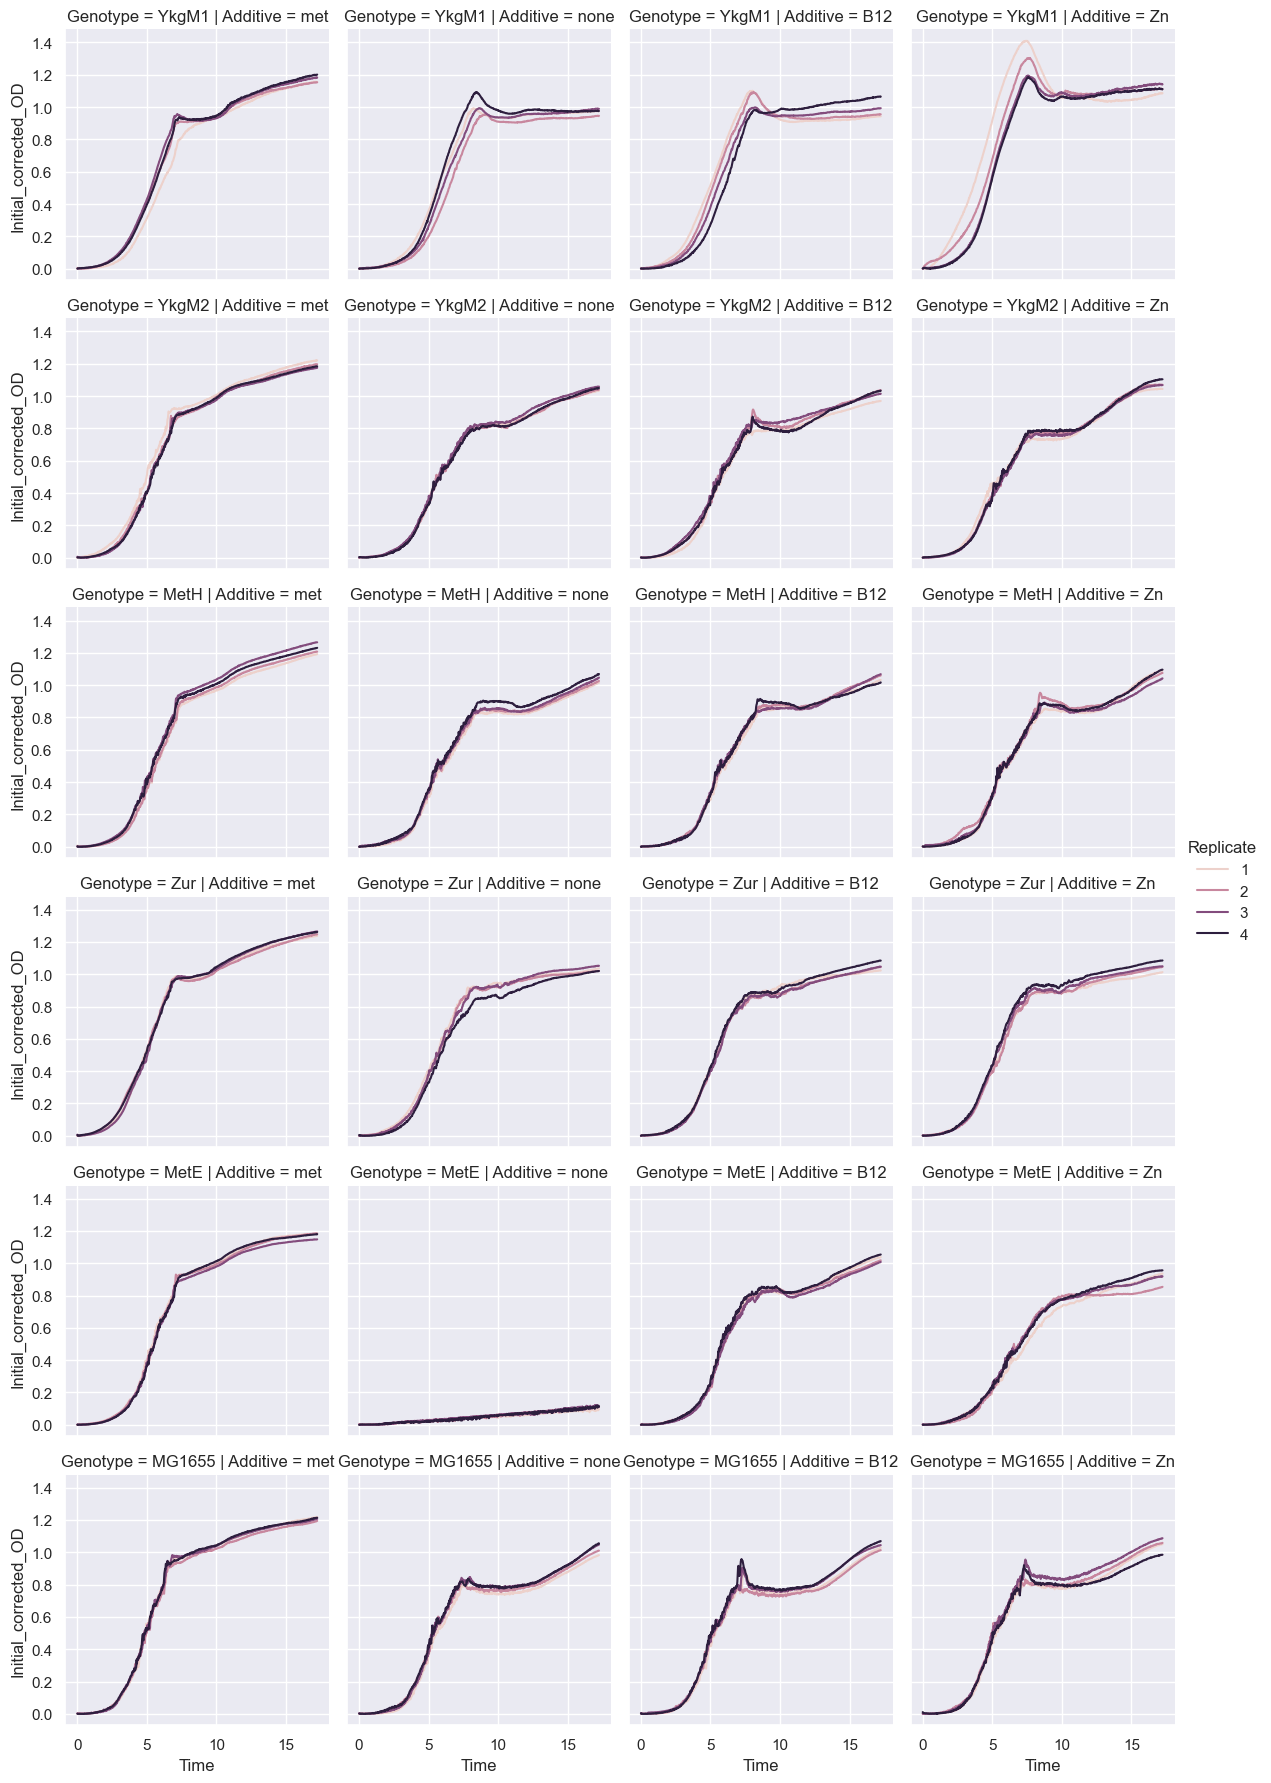

In [16]:
sns.relplot(x="Time", y="Initial_corrected_OD", hue="Replicate", kind="line", col="Additive", row="Genotype", height=3, \
            data=mdf)

In [17]:
f_mdf = mdf.filter(pl.col("Initial_corrected_OD") > 0)

f_mdf = f_mdf.with_columns([
    (pl.col("Initial_corrected_OD").log())
    .alias("Log_initial_corrected_OD")
])

f_mdf.head(5)

shape: (5, 13)
┌──────────┬──────┬───────┬─────┬───┬───────────┬────────────────┬────────────────┬────────────────┐
│ Time     ┆ Well ┆ OD    ┆ Row ┆ … ┆ Replicate ┆ Background_cor ┆ Initial_correc ┆ Log_initial_co │
│ ---      ┆ ---  ┆ ---   ┆ --- ┆   ┆ ---       ┆ rected_OD      ┆ ted_OD         ┆ rrected_OD     │
│ f64      ┆ str  ┆ f64   ┆ str ┆   ┆ i32       ┆ ---            ┆ ---            ┆ ---            │
│          ┆      ┆       ┆     ┆   ┆           ┆ f64            ┆ f64            ┆ f64            │
╞══════════╪══════╪═══════╪═════╪═══╪═══════════╪════════════════╪════════════════╪════════════════╡
│ 0.011111 ┆ A1   ┆ 0.171 ┆ A   ┆ … ┆ 1         ┆ 0.076762       ┆ 0.005          ┆ -5.298317      │
│ 0.036111 ┆ A1   ┆ 0.171 ┆ A   ┆ … ┆ 1         ┆ 0.076762       ┆ 0.005          ┆ -5.298317      │
│ 0.061111 ┆ A1   ┆ 0.169 ┆ A   ┆ … ┆ 1         ┆ 0.074762       ┆ 0.003          ┆ -5.809143      │
│ 0.086111 ┆ A1   ┆ 0.168 ┆ A   ┆ … ┆ 1         ┆ 0.073762       ┆ 0.002          ┆ -6.214608      │
│ 0.111111 ┆ A1   ┆ 0.169 ┆ A   ┆ … ┆ 1         ┆ 0.074762       ┆ 0.003          ┆ -5.809143      │
└──────────┴──────┴───────┴─────┴───┴───────────┴────────────────┴────────────────┴────────────────┘

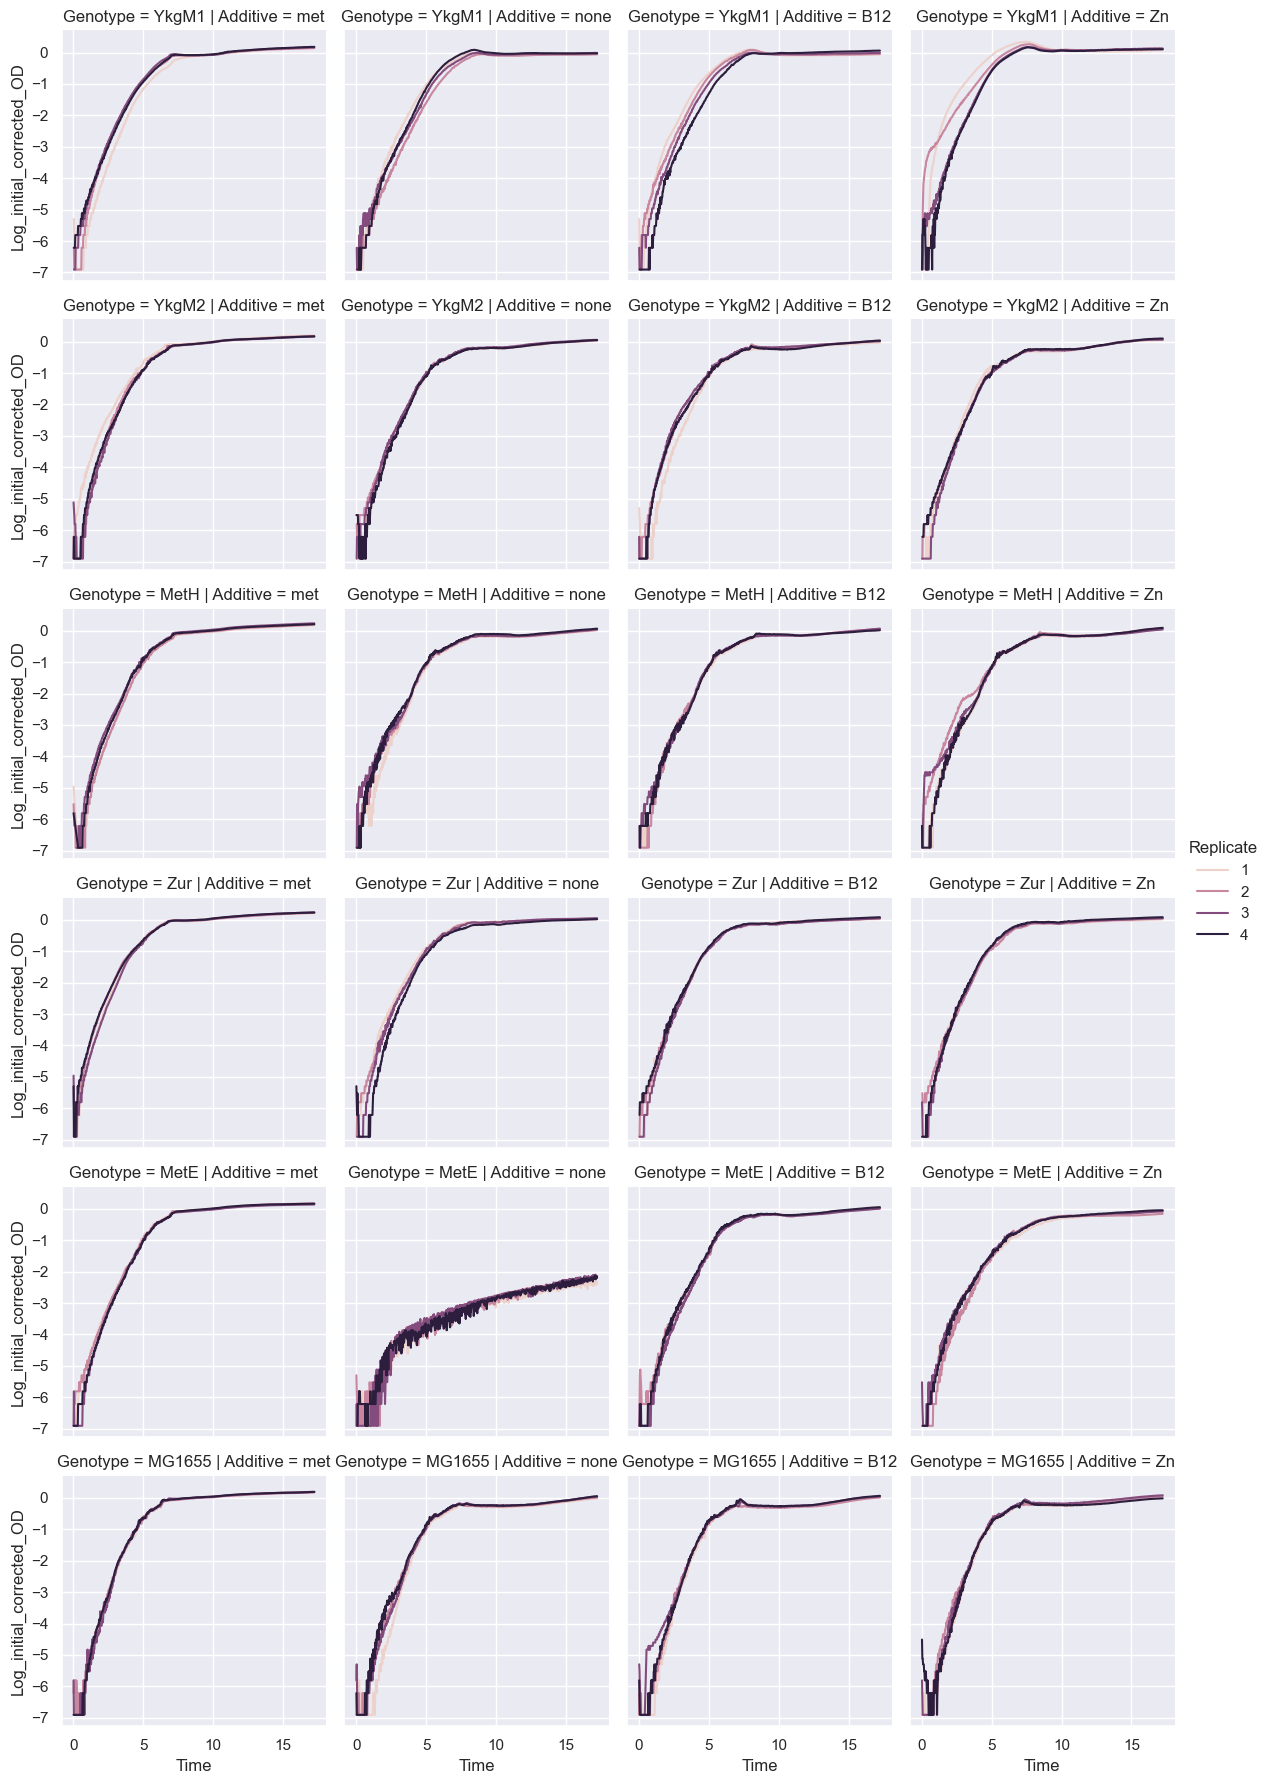

In [18]:
sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Replicate", kind="line", col="Additive", row="Genotype", height=3, \
            data=f_mdf)

In [133]:
gr_df = f_mdf.filter( (pl.col("Time") < 10))
minimum_start_times = gr_df.filter(pl.col("Log_initial_corrected_OD") <= -5).group_by("Well").agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = gr_df.filter(pl.col("Log_initial_corrected_OD") >= -2).group_by("Well").agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

gr_df = gr_df.join(minimum_start_times, on="Well")
gr_df = gr_df.join(minimum_end_times, on="Well")
gr_df = gr_df.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_df = gr_df.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))
gr_df

shape: (9_447, 16)
┌──────────┬──────┬───────┬─────┬───┬───────────────┬───────────────┬──────────────┬───────────────┐
│ Time     ┆ Well ┆ OD    ┆ Row ┆ … ┆ Log_initial_c ┆ Time_exp_star ┆ Time_exp_end ┆ Corrected_tim │
│ ---      ┆ ---  ┆ ---   ┆ --- ┆   ┆ orrected_OD   ┆ t             ┆ ---          ┆ e             │
│ f64      ┆ str  ┆ f64   ┆ str ┆   ┆ ---           ┆ ---           ┆ f64          ┆ ---           │
│          ┆      ┆       ┆     ┆   ┆ f64           ┆ f64           ┆              ┆ f64           │
╞══════════╪══════╪═══════╪═════╪═══╪═══════════════╪═══════════════╪══════════════╪═══════════════╡
│ 1.436111 ┆ A1   ┆ 0.173 ┆ A   ┆ … ┆ -4.961845     ┆ 1.411111      ┆ 3.911111     ┆ 0.025         │
│ 1.461111 ┆ A1   ┆ 0.173 ┆ A   ┆ … ┆ -4.961845     ┆ 1.411111      ┆ 3.911111     ┆ 0.05          │
│ 1.486111 ┆ A1   ┆ 0.173 ┆ A   ┆ … ┆ -4.961845     ┆ 1.411111      ┆ 3.911111     ┆ 0.075         │
│ 1.511111 ┆ A1   ┆ 0.173 ┆ A   ┆ … ┆ -4.961845     ┆ 1.411111      ┆ 3.911111     ┆ 0.1           │
│ 1.536111 ┆ A1   ┆ 0.174 ┆ A   ┆ … ┆ -4.828314     ┆ 1.411111      ┆ 3.911111     ┆ 0.125         │
│ …        ┆ …    ┆ …     ┆ …   ┆ … ┆ …             ┆ …             ┆ …            ┆ …             │
│ 3.461111 ┆ H12  ┆ 0.28  ┆ H   ┆ … ┆ -2.189256     ┆ 1.536111      ┆ 3.586111     ┆ 1.925         │
│ 3.486111 ┆ H12  ┆ 0.281 ┆ H   ┆ … ┆ -2.180367     ┆ 1.536111      ┆ 3.586111     ┆ 1.95          │
│ 3.511111 ┆ H12  ┆ 0.285 ┆ H   ┆ … ┆ -2.145581     ┆ 1.536111      ┆ 3.586111     ┆ 1.975         │
│ 3.536111 ┆ H12  ┆ 0.291 ┆ H   ┆ … ┆ -2.095571     ┆ 1.536111      ┆ 3.586111     ┆ 2.0           │
│ 3.561111 ┆ H12  ┆ 0.297 ┆ H   ┆ … ┆ -2.047943     ┆ 1.536111      ┆ 3.586111     ┆ 2.025         │
└──────────┴──────┴───────┴─────┴───┴───────────────┴───────────────┴──────────────┴───────────────┘

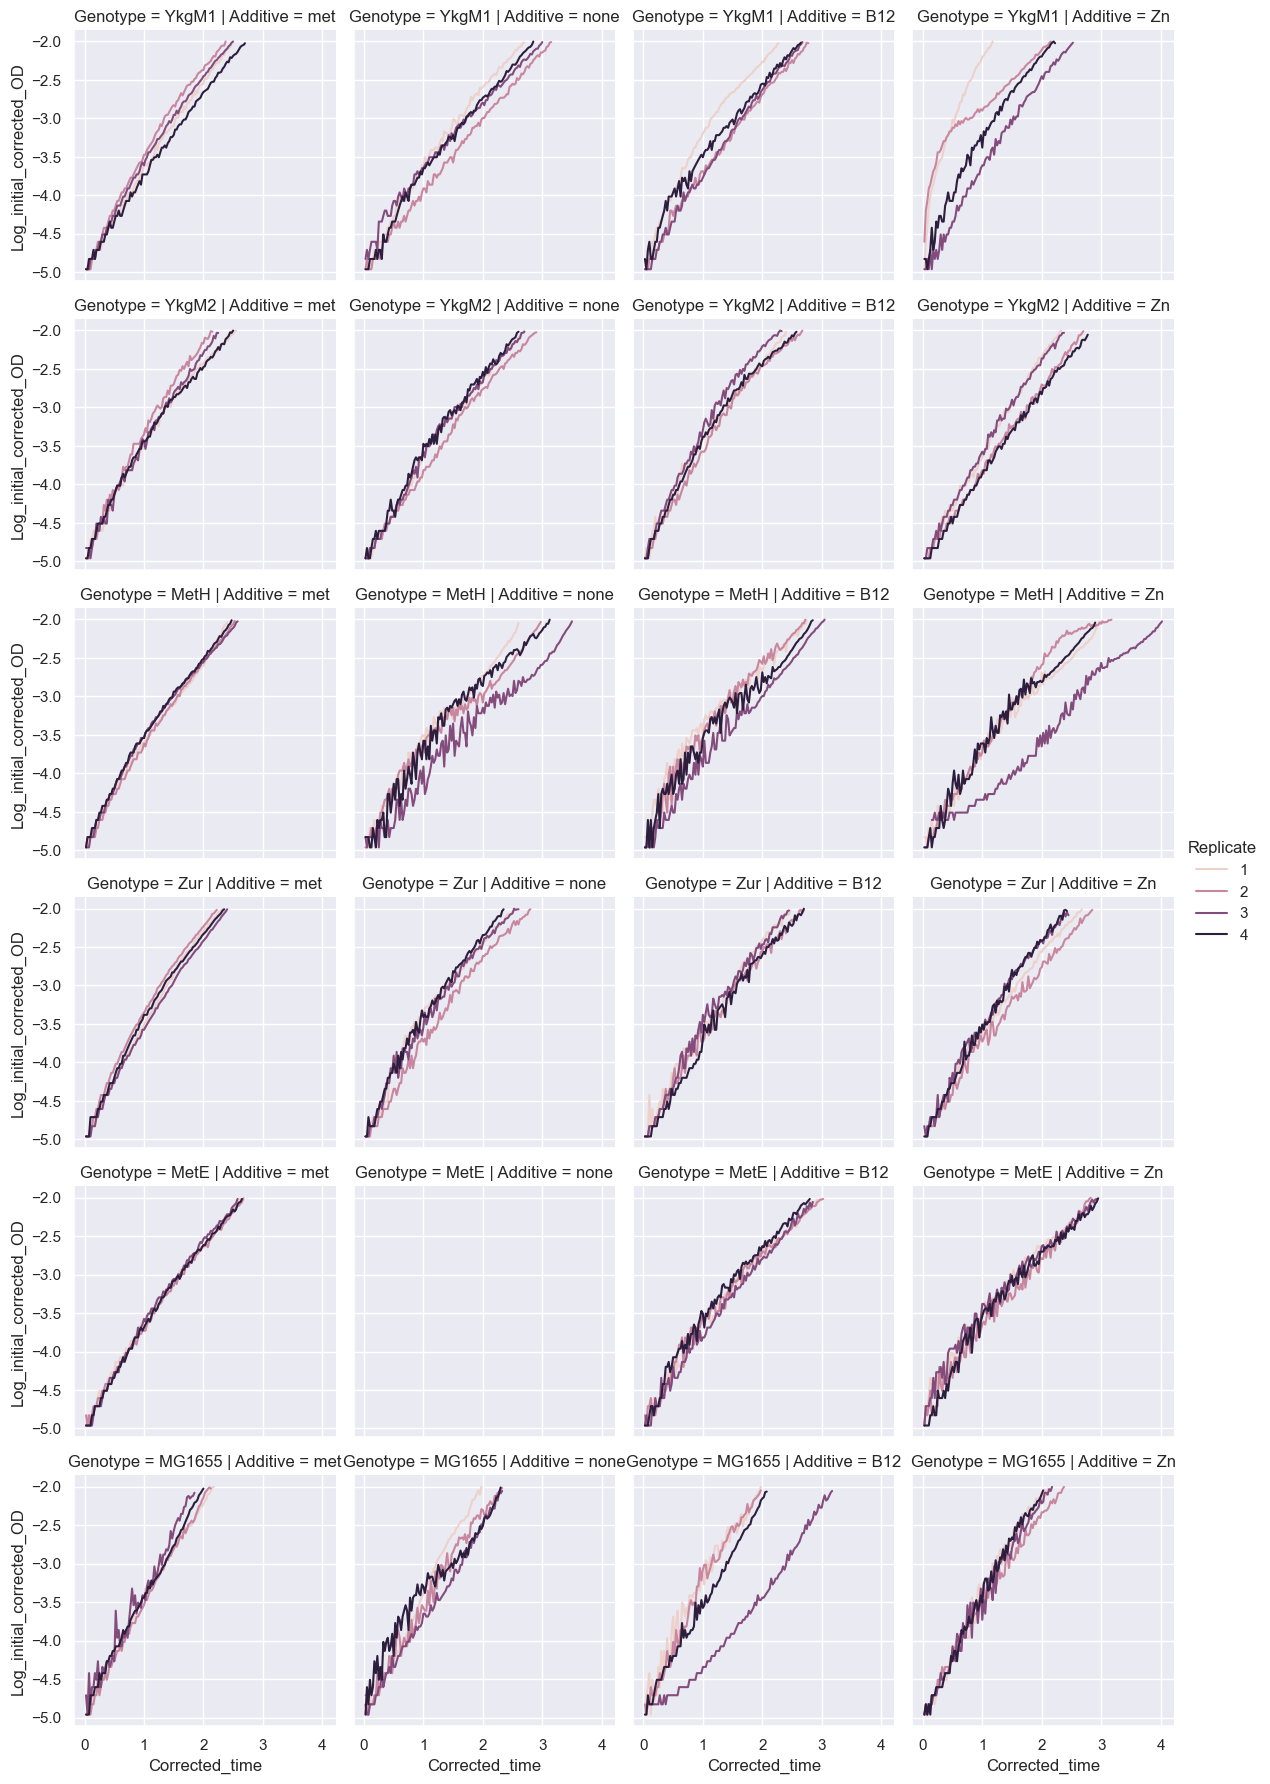

In [134]:
sns.relplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Replicate", kind="line", col="Additive", row="Genotype", height=3, \
            data=gr_df)

In [135]:
predicted_gr = gr_df \
.to_pandas().groupby(['Genotype', 'Additive','Replicate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time'])
predicted_gr["doubling_time"] = np.log(2) / predicted_gr["slope"]
predicted_gr = predicted_gr.reset_index()


gr_mean_std = predicted_gr.groupby(['Genotype', 'Additive']).agg({'slope':['mean','std']})
gr_mean_std.columns = gr_mean_std.columns.get_level_values(1)
gr_mean_std["doubling_time"] = np.log(2)/gr_mean_std["mean"]
# gr_mean_std = gr_mean_std.reset_index()

predicted_gr["doubling_time"] = np.log(2)/predicted_gr["slope"]

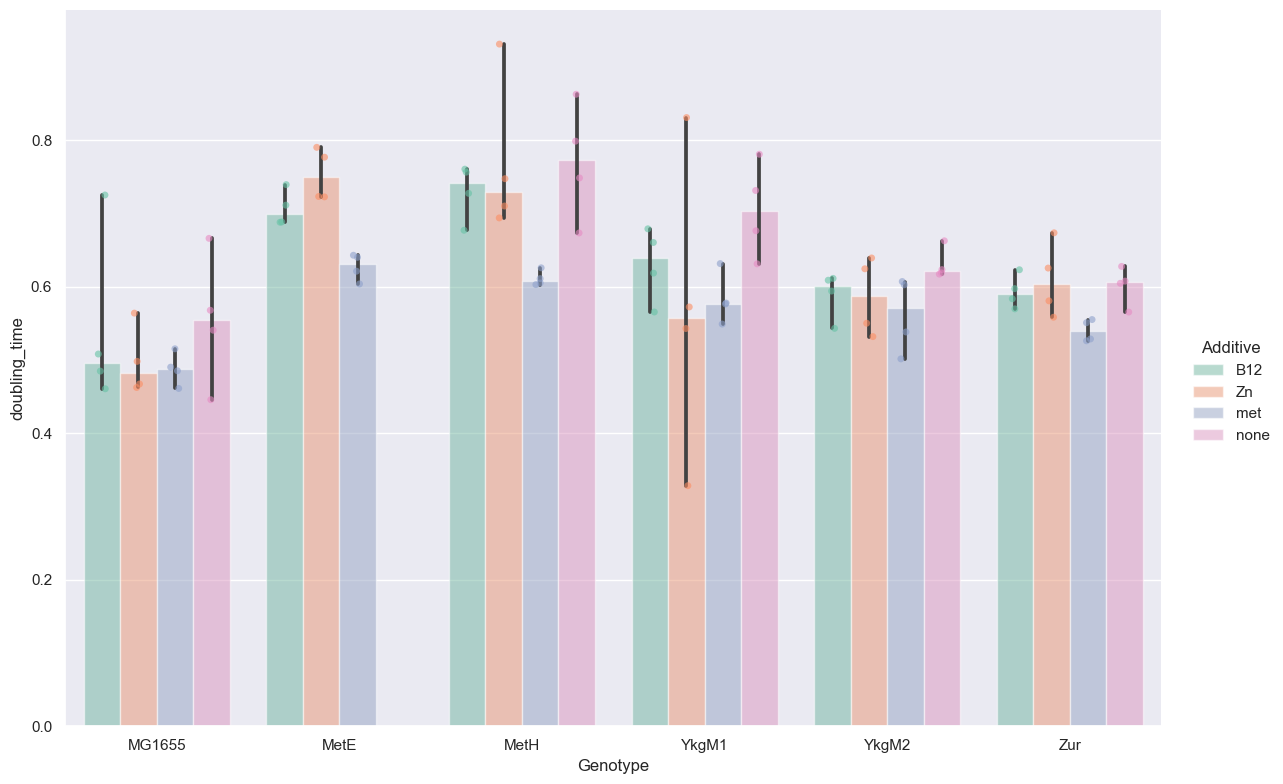

In [138]:
g = sns.catplot(x="Genotype", y="doubling_time", hue="Additive", 
                data=predicted_gr, kind="bar", estimator="median",
                height=8, aspect=1.5, alpha=0.5);
g.map_dataframe(sns.stripplot, x="Genotype", y="doubling_time", 
                hue="Additive", palette="Set2",
                alpha=0.6, dodge=True)
# g.map(sns.stripplot, "sex", "total_bill", "smoker", 
#       palette=["#404040"], alpha=0.6, dodge=True)
# plt.ylim([0, 1])

plt.show()

In [94]:
import warnings
warnings.filterwarnings('ignore')

wells = list(f_mdf["Well"].unique())
timepoints = list(f_mdf["Time"].unique())
window = 50

well_fits = {}

for well in wells:

    fits = []
    
    for i, time in enumerate(timepoints):

        
        cur_df = f_mdf.filter(
            (pl.col("Well") == well) & 
            (pl.col("Time").is_in(timepoints[i:i+window]) )
        )

        fit = np.polyfit(cur_df["Time"],cur_df["Log_initial_corrected_OD"], 1)[0]

        fits.append(fit)

        # print(f"for well {well} at time {time}, the instantenous slope is {fit}")

    well_fits[well] = fits

In [95]:
wf_df = pl.DataFrame(well_fits)
wf_df = wf_df.with_columns(pl.arange(0, len(wf_df)).alias("Step"))


# melt to experiments
wf_df = wf_df.melt(id_vars="Step", variable_name="Well", value_name="Slope")
wf_df = wf_df.with_columns((wf_df["Well"].str.slice(0,1)).alias("Row"))
wf_df = wf_df.with_columns((wf_df["Well"].str.slice(1)).alias("Column"))

wf_df = wf_df.join(adf, on="Row")
wf_df = wf_df.join(gdf, on="Well")

wf_df = wf_df.with_columns(((pl.col("Column").cast(pl.Int32)+3) % 4 + 1).alias("Replicate"))

wf_df.head(5)

shape: (5, 8)
┌──────┬──────┬──────────┬─────┬────────┬──────────┬──────────┬───────────┐
│ Step ┆ Well ┆ Slope    ┆ Row ┆ Column ┆ Additive ┆ Genotype ┆ Replicate │
│ ---  ┆ ---  ┆ ---      ┆ --- ┆ ---    ┆ ---      ┆ ---      ┆ ---       │
│ i64  ┆ str  ┆ f64      ┆ str ┆ str    ┆ str      ┆ str      ┆ i32       │
╞══════╪══════╪══════════╪═════╪════════╪══════════╪══════════╪═══════════╡
│ 0    ┆ G11  ┆ 2.032189 ┆ G   ┆ 11     ┆ B12      ┆ MG1655   ┆ 3         │
│ 1    ┆ G11  ┆ 2.138439 ┆ G   ┆ 11     ┆ B12      ┆ MG1655   ┆ 3         │
│ 2    ┆ G11  ┆ 2.221511 ┆ G   ┆ 11     ┆ B12      ┆ MG1655   ┆ 3         │
│ 3    ┆ G11  ┆ 2.234874 ┆ G   ┆ 11     ┆ B12      ┆ MG1655   ┆ 3         │
│ 4    ┆ G11  ┆ 2.242202 ┆ G   ┆ 11     ┆ B12      ┆ MG1655   ┆ 3         │
└──────┴──────┴──────────┴─────┴────────┴──────────┴──────────┴───────────┘

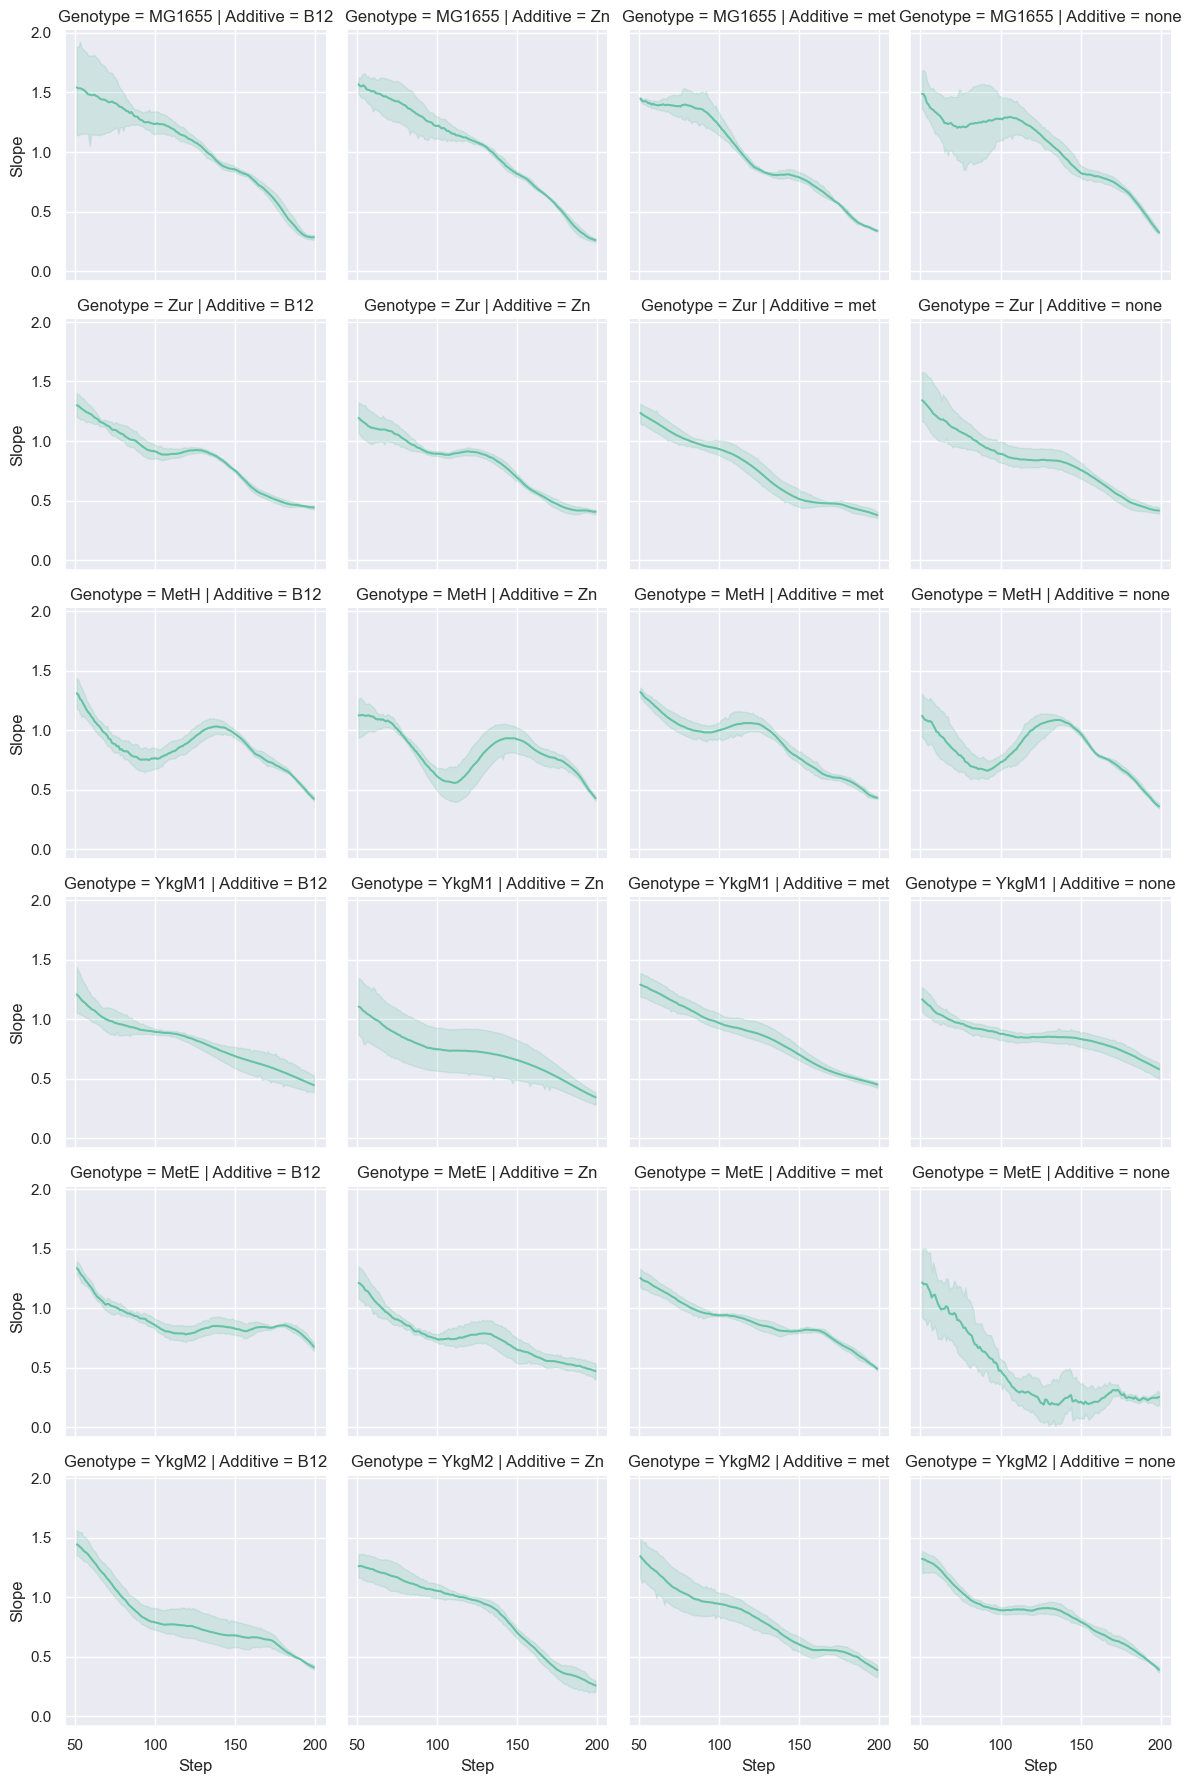

In [96]:
sns.relplot(x="Step", y="Slope", kind="line", col="Additive", row="Genotype", height=3, \
            data=wf_df.filter(
                (pl.col("Step") > 50) & (pl.col("Step") < 200) & (pl.col("Slope") > 0)  & (pl.col("Slope") < 2.5)
            )
           )

# Mut

In [320]:
additive = {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met", "F": "none", "G": "B12", "H": "Zn"}
adf = pl.DataFrame(additive).transpose(include_header=True)
adf = adf.rename({"column": "Row", "column_0": "Additive"})

In [321]:
genotype_row = [["A", "B", "C", "D"], ["E", "F", "G", "H"]]
genotype_col = [["1", "2", "3", "4"], ["5", "6", "7", "8"], ["9", "10", "11", "12"]]

genotype_combinations = {"YkgM1": [0, 0], "YkgM2": [0, 1], "MetH": [0, 2], "Zur": [1, 0], "MetE": [1, 1], "MG1655": [1, 2]}

In [322]:
gdf = []

for genotype, idx in genotype_combinations.items():

    gdf.extend([[genotype, x+y] for x in genotype_row[idx[0]] for y in genotype_col[idx[1]]])

gdf

gdf = pl.DataFrame(gdf).transpose()
gdf = gdf.rename({"column_0": "Genotype", "column_1": "Well"})

In [323]:
df = pl.read_csv("growth_data/cyrus_mutant_013124.txt", separator="\t")
df = df.drop('T600')
df.head(3)

shape: (3, 97)
┌─────────┬───────┬───────┬───────┬───┬───────┬───────┬───────┬───────┐
│ Time    ┆ A1    ┆ A2    ┆ A3    ┆ … ┆ H9    ┆ H10   ┆ H11   ┆ H12   │
│ ---     ┆ ---   ┆ ---   ┆ ---   ┆   ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ str     ┆ f64   ┆ f64   ┆ f64   ┆   ┆ f64   ┆ f64   ┆ f64   ┆ f64   │
╞═════════╪═══════╪═══════╪═══════╪═══╪═══════╪═══════╪═══════╪═══════╡
│ 0:01:02 ┆ 0.172 ┆ 0.159 ┆ 0.127 ┆ … ┆ 0.162 ┆ 0.153 ┆ 0.142 ┆ 0.124 │
│ 0:04:02 ┆ 0.171 ┆ 0.157 ┆ 0.126 ┆ … ┆ 0.166 ┆ 0.159 ┆ 0.151 ┆ 0.125 │
│ 0:07:02 ┆ 0.17  ┆ 0.157 ┆ 0.126 ┆ … ┆ 0.164 ┆ 0.143 ┆ 0.134 ┆ 0.123 │
└─────────┴───────┴───────┴───────┴───┴───────┴───────┴───────┴───────┘

In [324]:
# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(df['Time'].dt.hour().cast(pl.Int64) + df['Time'].dt.minute().cast(pl.Int64) / 60 + df['Time'].dt.second() / 3600)

# zero by first measurement
df = df.with_columns([pl.col(c) - df[0, c] for c in df.columns])

# melt to experiments
df = df.melt(id_vars="Time", variable_name="Well", value_name="OD")
df = df.with_columns((df["Well"].str.slice(0,1)).alias("Row"))
df = df.with_columns((df["Well"].str.slice(1)).alias("Column"))

df = df.filter(pl.col("OD") > 0)

mdf = df.join(adf, on="Row")
mdf = mdf.join(gdf, on="Well")
mdf

mdf = mdf.with_columns(((pl.col("Column").cast(pl.Int32)+3) % 4 + 1).alias("Replicate"))
mdf.head(3)

shape: (3, 8)
┌──────┬──────┬───────┬─────┬────────┬──────────┬──────────┬───────────┐
│ Time ┆ Well ┆ OD    ┆ Row ┆ Column ┆ Additive ┆ Genotype ┆ Replicate │
│ ---  ┆ ---  ┆ ---   ┆ --- ┆ ---    ┆ ---      ┆ ---      ┆ ---       │
│ f64  ┆ str  ┆ f64   ┆ str ┆ str    ┆ str      ┆ str      ┆ i32       │
╞══════╪══════╪═══════╪═════╪════════╪══════════╪══════════╪═══════════╡
│ 1.15 ┆ A1   ┆ 0.001 ┆ A   ┆ 1      ┆ met      ┆ YkgM1    ┆ 1         │
│ 1.2  ┆ A1   ┆ 0.001 ┆ A   ┆ 1      ┆ met      ┆ YkgM1    ┆ 1         │
│ 1.25 ┆ A1   ┆ 0.001 ┆ A   ┆ 1      ┆ met      ┆ YkgM1    ┆ 1         │
└──────┴──────┴───────┴─────┴────────┴──────────┴──────────┴───────────┘

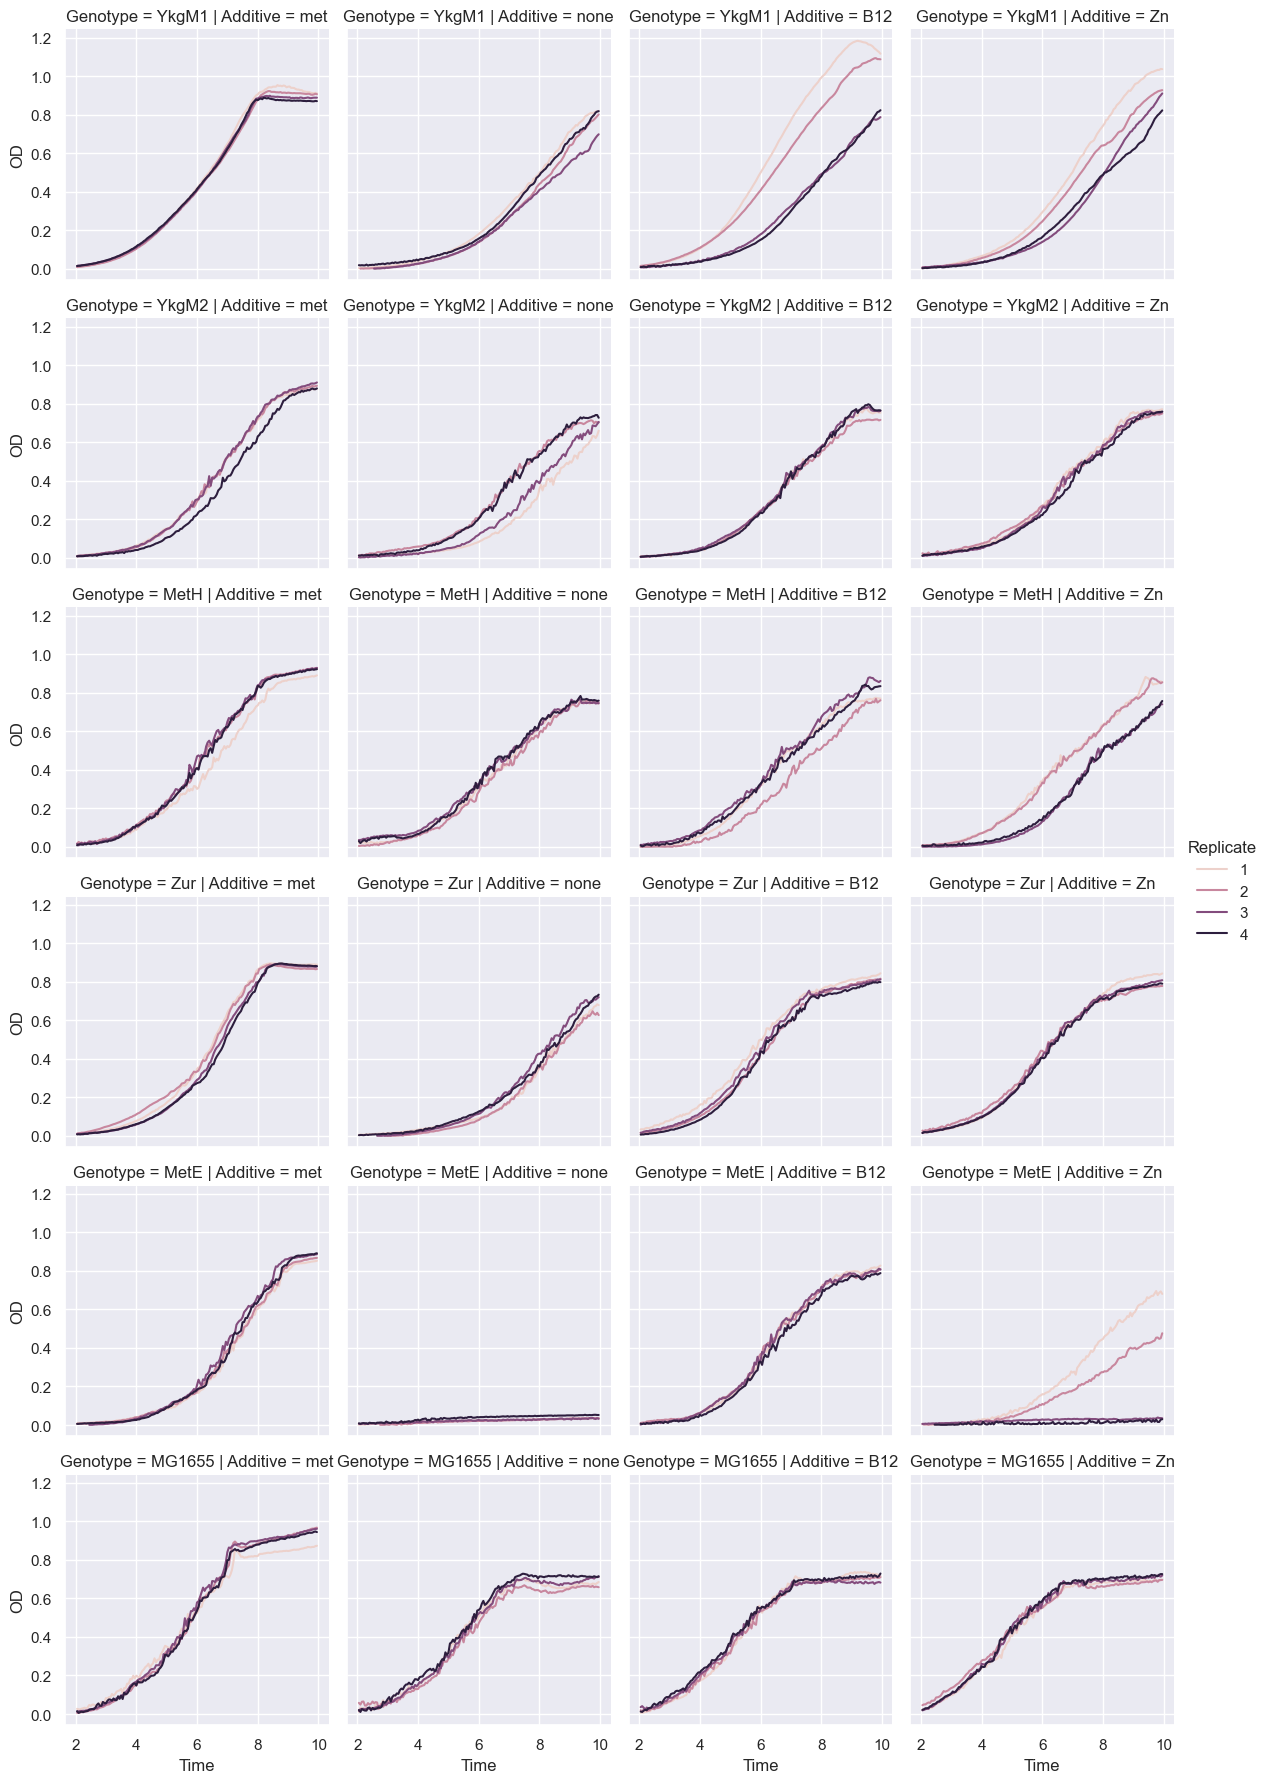

In [325]:
sns.relplot(x="Time", y="OD", hue="Replicate", kind="line", col="Additive", row="Genotype", height=3, \
            data=mdf.filter( (pl.col("Time") < 10) & (pl.col("Time") > 2) ))

In [326]:
mdf = mdf.with_columns(pl.col("OD").log())

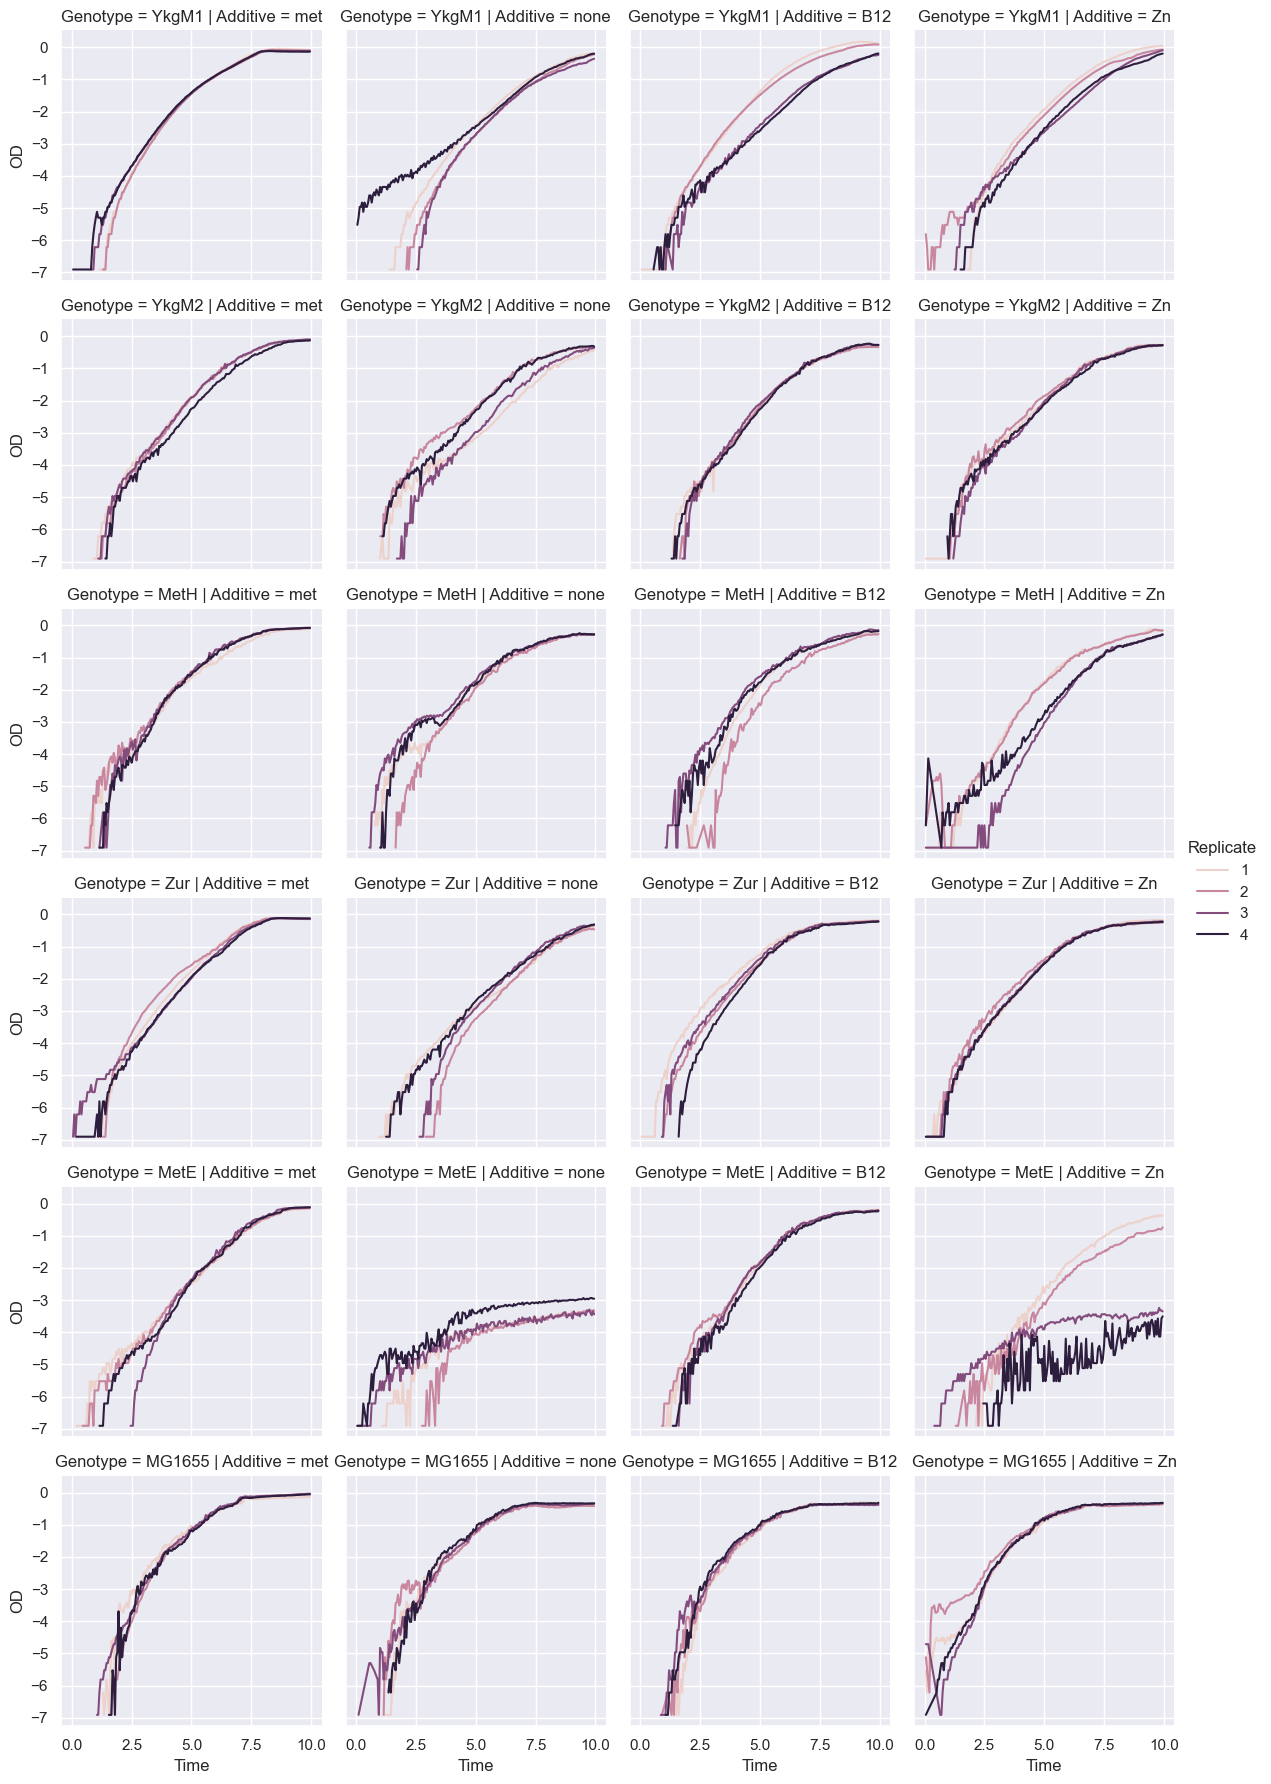

In [327]:
sns.relplot(x="Time", y="OD", hue="Replicate", kind="line", col="Additive", row="Genotype", height=3, \
            data=mdf.filter( (pl.col("Time") < 10)))

In [334]:
growth_rate_precise = mdf.filter( (pl.col("Time") < 10))

minimum_start_times = growth_rate_precise.filter(pl.col("OD") <= -4).group_by("Well").agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = growth_rate_precise.filter(pl.col("OD") >= -1).group_by("Well").agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

growth_rate_precise = growth_rate_precise.join(minimum_start_times, on="Well")
growth_rate_precise = growth_rate_precise.join(minimum_end_times, on="Well")
gr_time_filter = growth_rate_precise.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_time_filter = gr_time_filter.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))

# correct all od values to start at 0
# start_od = gr_time_filter.group_by("Well").agg(pl.min("OD").alias("Start_OD")).sort("Start_OD")
# gr_time_filter = gr_time_filter.join(start_od, on="Well")
# gr_time_filter = gr_time_filter.with_columns((pl.col("OD") - pl.col("Start_OD")).alias("Corrected_OD"))

# correct by linear fit

#This is what you need
correction_offset = gr_time_filter.to_pandas().groupby('Well').apply(regress, 'OD', ['Corrected_time'])
correction_offset = correction_offset.reset_index()
correction_offset = pl.DataFrame(correction_offset)

gr_time_filter

shape: (6_469, 11)
┌──────┬──────┬───────────┬─────┬───┬───────────┬────────────────┬──────────────┬────────────────┐
│ Time ┆ Well ┆ OD        ┆ Row ┆ … ┆ Replicate ┆ Time_exp_start ┆ Time_exp_end ┆ Corrected_time │
│ ---  ┆ ---  ┆ ---       ┆ --- ┆   ┆ ---       ┆ ---            ┆ ---          ┆ ---            │
│ f64  ┆ str  ┆ f64       ┆ str ┆   ┆ i32       ┆ f64            ┆ f64          ┆ f64            │
╞══════╪══════╪═══════════╪═════╪═══╪═══════════╪════════════════╪══════════════╪════════════════╡
│ 2.5  ┆ A1   ┆ -3.912023 ┆ A   ┆ … ┆ 1         ┆ 2.45           ┆ 5.75         ┆ 0.05           │
│ 2.55 ┆ A1   ┆ -3.863233 ┆ A   ┆ … ┆ 1         ┆ 2.45           ┆ 5.75         ┆ 0.1            │
│ 2.6  ┆ A1   ┆ -3.816713 ┆ A   ┆ … ┆ 1         ┆ 2.45           ┆ 5.75         ┆ 0.15           │
│ 2.65 ┆ A1   ┆ -3.729701 ┆ A   ┆ … ┆ 1         ┆ 2.45           ┆ 5.75         ┆ 0.2            │
│ 2.7  ┆ A1   ┆ -3.688879 ┆ A   ┆ … ┆ 1         ┆ 2.45           ┆ 5.75         ┆ 0.25           │
│ …    ┆ …    ┆ …         ┆ …   ┆ … ┆ …         ┆ …              ┆ …            ┆ …              │
│ 4.35 ┆ H12  ┆ -1.294627 ┆ H   ┆ … ┆ 4         ┆ 1.8            ┆ 4.6          ┆ 2.55           │
│ 4.4  ┆ H12  ┆ -1.272966 ┆ H   ┆ … ┆ 4         ┆ 1.8            ┆ 4.6          ┆ 2.6            │
│ 4.45 ┆ H12  ┆ -1.145704 ┆ H   ┆ … ┆ 4         ┆ 1.8            ┆ 4.6          ┆ 2.65           │
│ 4.5  ┆ H12  ┆ -1.148854 ┆ H   ┆ … ┆ 4         ┆ 1.8            ┆ 4.6          ┆ 2.7            │
│ 4.55 ┆ H12  ┆ -1.090644 ┆ H   ┆ … ┆ 4         ┆ 1.8            ┆ 4.6          ┆ 2.75           │
└──────┴──────┴───────────┴─────┴───┴───────────┴────────────────┴──────────────┴────────────────┘

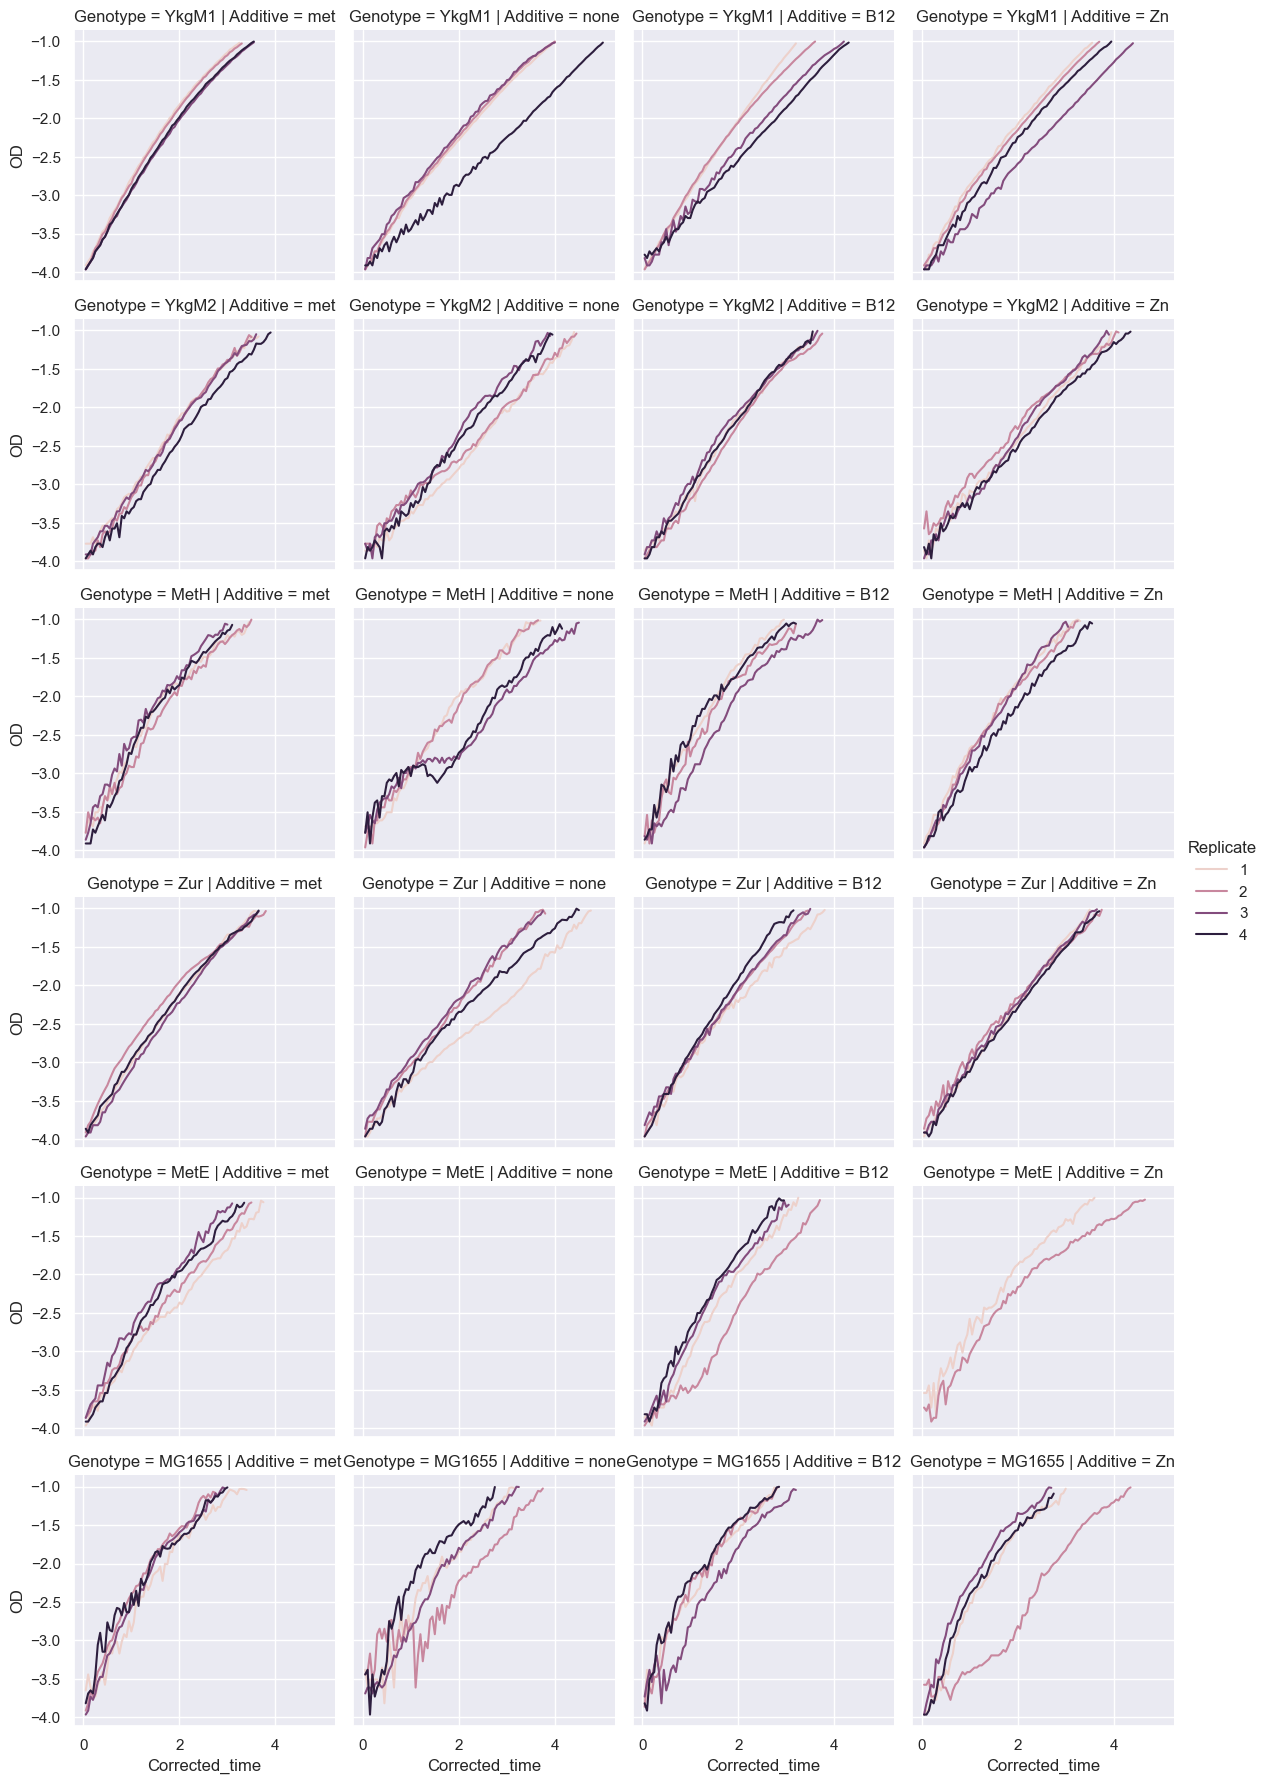

In [335]:
sns.relplot(x="Corrected_time", y="OD", hue="Replicate", kind="line", col="Additive", row="Genotype", height=3, \
            data=gr_time_filter)

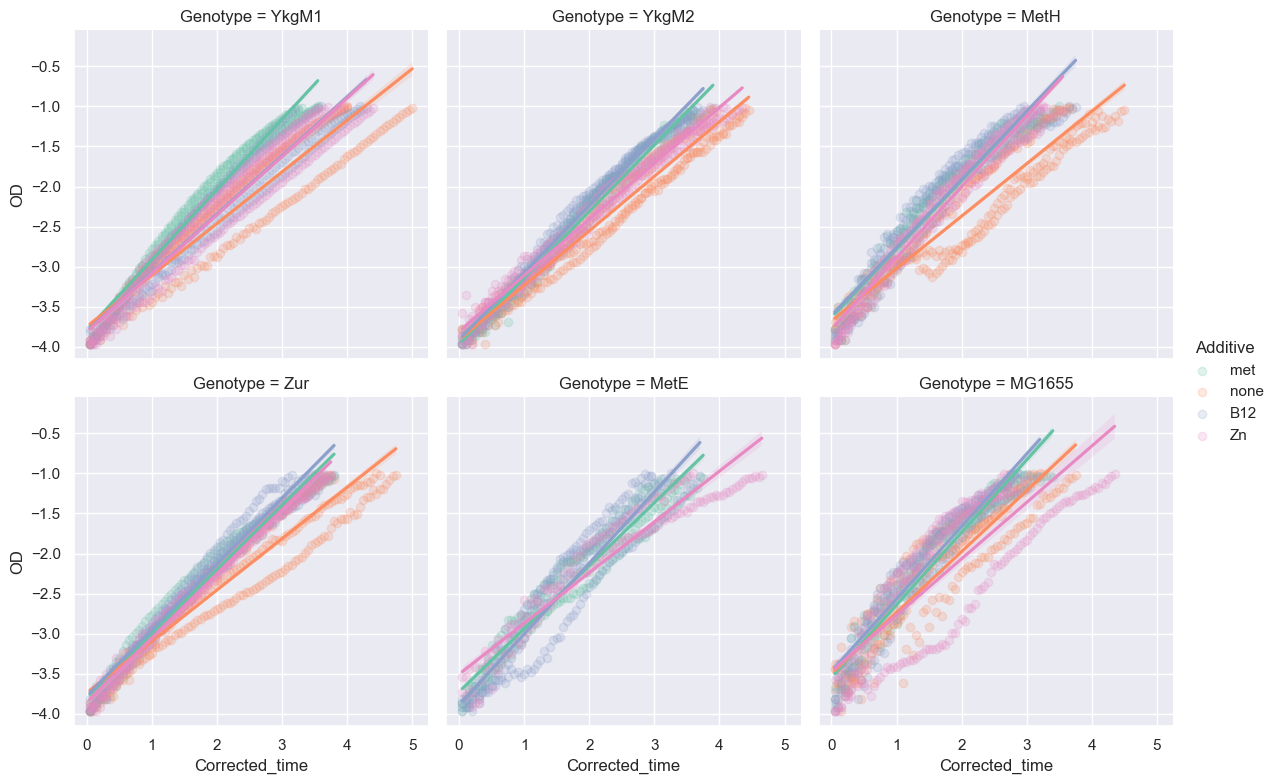

In [336]:
sns.lmplot(x="Corrected_time", y="OD", hue="Additive", col="Genotype", col_wrap=3, height=4, 
           data=gr_time_filter.to_pandas(), scatter_kws = {"alpha": 0.2})

In [337]:
predicted_gr = gr_time_filter \
.to_pandas().groupby(['Genotype', 'Additive','Replicate']).apply(regress_error, 'OD', ['Corrected_time'])
predicted_gr["doubling_time"] = np.log(2) / predicted_gr["slope"]
predicted_gr = predicted_gr.reset_index()


gr_mean_std = predicted_gr.groupby(['Genotype', 'Additive']).agg({'slope':['mean','std']})
gr_mean_std["doubling_time"] = np.log(2)/gr_mean_std.xs('slope',  axis=1)["mean"]
gr_mean_std

slope           doubling_time
                       mean       std              
Genotype Additive                                  
MG1655   B12       0.922611  0.026839      0.751289
         Zn        0.947496  0.154998      0.731557
         met       0.929794  0.082714      0.745484
         none      0.838549  0.140036      0.826603
MetE     B12       0.941972  0.075341      0.735847
         Zn        0.686730  0.100918      1.009345
         met       0.814380  0.068374      0.851135
MetH     B12       0.886773  0.058650      0.781651
         Zn        0.903215  0.061184      0.767422
         met       0.871909  0.070997      0.794976
         none      0.701928  0.124873      0.987490
YkgM1    B12       0.790357  0.110978      0.877005
         Zn        0.764328  0.053613      0.906871
         met       0.884611  0.032048      0.783562
         none      0.700347  0.073838      0.989720
YkgM2    B12       0.835925  0.021437      0.829198
         Zn        0.703355  0.046622      0.985487
         met       0.835545  0.034440      0.829575
         none      0.700234  0.071475      0.989880
Zur      B12       0.845047  0.083319      0.820247
         Zn        0.801663  0.044125      0.864637
         met       0.799204  0.053327      0.867297
         none      0.689725  0.084765      1.004961

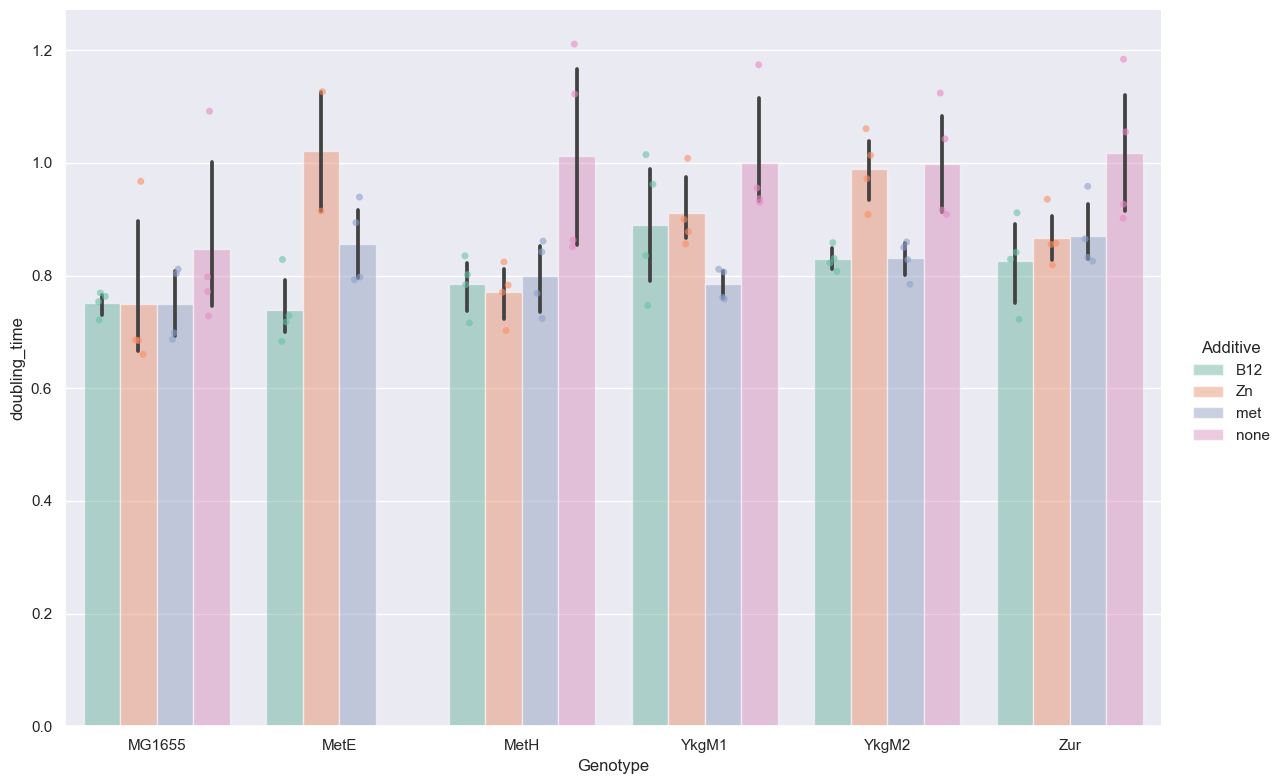

In [338]:
g = sns.catplot(x="Genotype", y="doubling_time", hue="Additive", 
                data=predicted_gr, kind="bar",
                height=8, aspect=1.5, alpha=0.5);
g.map_dataframe(sns.stripplot, x="Genotype", y="doubling_time", 
                hue="Additive", palette="Set2",
                alpha=0.6, dodge=True)
# g.map(sns.stripplot, "sex", "total_bill", "smoker", 
#       palette=["#404040"], alpha=0.6, dodge=True)
plt.show()

# Reanalyzing the old plate lol

In [16]:
# plate 2
df = pl.read_csv("growth_data/cyrus_012624.csv")
df = df.drop('T600')

# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(df['Time'].dt.hour().cast(pl.Int64) + df['Time'].dt.minute().cast(pl.Int64) / 60 + df['Time'].dt.second() / 3600)

# zero by first measurement
# df = df.with_columns([pl.col(c) - df[0, c] for c in df.columns])

# melt to experiments
df = df.melt(id_vars="Time", variable_name="Well", value_name="OD")
df = df.with_columns((df["Well"].str.slice(0,1)).alias("Experiment"))
df = df.with_columns((df["Well"].str.slice(1)).alias("Replicate"))
df = df.with_columns(pl.col("OD").log())


In [17]:
# join with experiment type
column_names = ["Experiment", "Abb", "Description", "Pre-met", "Additive"]
conversion = [["A", "Rrm", "Rich + met, ++met", True, "met"], 
              ["B", "Rr", "Rich - met, ++met", True, "none"], 
              ["C", "RrZ", "Rich - met + Zn, ++met", True, "zinc"], 
              ["D", "Rrb", "Rich - met + B12, ++met", True, "B12"],
              ["E", "rm", "Rich + met, --met", False, "met"],
              ["F", "r", "Rich - met, --met", False, "none"],
              ["G", "rz", "Rich - met, --met", False, "zinc"],
              ["H", "rb", "Rich - met, --met", False, "B12"]]

exp = pl.DataFrame(conversion)
exp.columns = column_names

exp

shape: (8, 5)
┌────────────┬─────┬─────────────────────────┬─────────┬──────────┐
│ Experiment ┆ Abb ┆ Description             ┆ Pre-met ┆ Additive │
│ ---        ┆ --- ┆ ---                     ┆ ---     ┆ ---      │
│ str        ┆ str ┆ str                     ┆ bool    ┆ str      │
╞════════════╪═════╪═════════════════════════╪═════════╪══════════╡
│ A          ┆ Rrm ┆ Rich + met, ++met       ┆ true    ┆ met      │
│ B          ┆ Rr  ┆ Rich - met, ++met       ┆ true    ┆ none     │
│ C          ┆ RrZ ┆ Rich - met + Zn, ++met  ┆ true    ┆ zinc     │
│ D          ┆ Rrb ┆ Rich - met + B12, ++met ┆ true    ┆ B12      │
│ E          ┆ rm  ┆ Rich + met, --met       ┆ false   ┆ met      │
│ F          ┆ r   ┆ Rich - met, --met       ┆ false   ┆ none     │
│ G          ┆ rz  ┆ Rich - met, --met       ┆ false   ┆ zinc     │
│ H          ┆ rb  ┆ Rich - met, --met       ┆ false   ┆ B12      │
└────────────┴─────┴─────────────────────────┴─────────┴──────────┘

In [18]:
mdf = df.join(exp, on="Experiment")

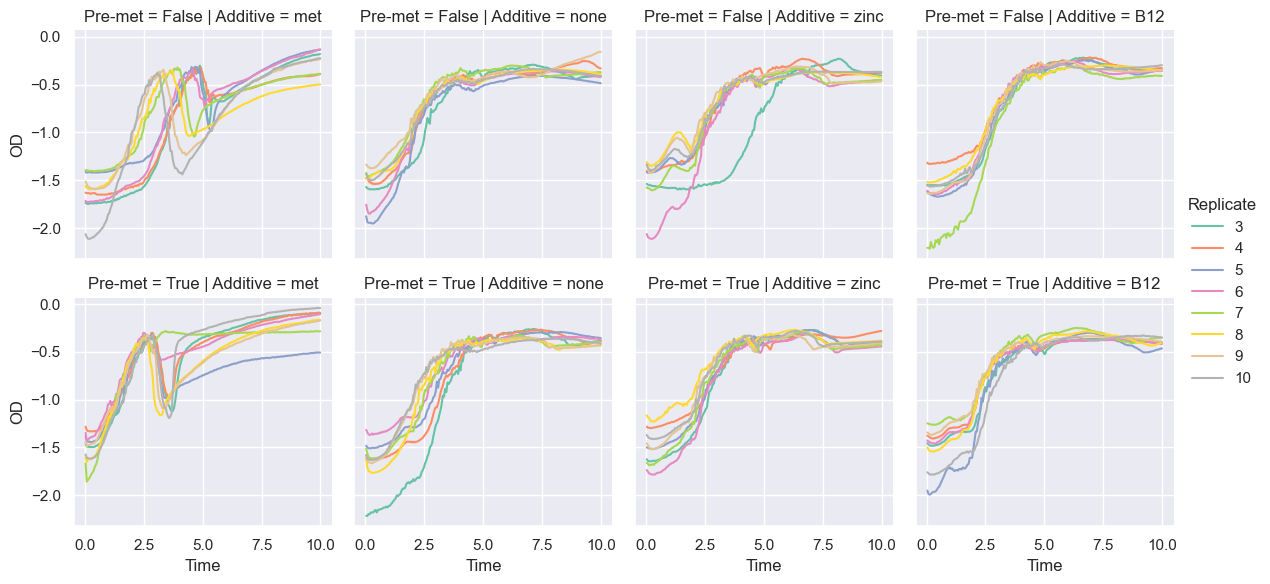

In [19]:
sns.relplot(x="Time", y="OD", hue="Replicate", kind="line", col="Additive", row="Pre-met", height=3, \
            data=mdf.filter( (pl.col("Time") < 10) & (pl.col("Time") > 0) ))

In [20]:
growth_rate_precise = mdf.filter( (pl.col("Time") < 10))

minimum_start_times = growth_rate_precise.filter(pl.col("OD") <= -0.9).group_by("Well").agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = growth_rate_precise.filter(pl.col("OD") >= -0.5).group_by("Well").agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

growth_rate_precise = growth_rate_precise.join(minimum_start_times, on="Well")
growth_rate_precise = growth_rate_precise.join(minimum_end_times, on="Well")
gr_time_filter = growth_rate_precise.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_time_filter = gr_time_filter.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))

# correct all od values to start at 0
# start_od = gr_time_filter.group_by("Well").agg(pl.min("OD").alias("Start_OD")).sort("Start_OD")
# gr_time_filter = gr_time_filter.join(start_od, on="Well")
# gr_time_filter = gr_time_filter.with_columns((pl.col("OD") - pl.col("Start_OD")).alias("Corrected_OD"))

# correct by linear fit

#This is what you need
correction_offset = gr_time_filter.to_pandas().groupby('Well').apply(regress, 'OD', ['Corrected_time'])
correction_offset = correction_offset.reset_index()
correction_offset = pl.DataFrame(correction_offset)

gr_time_filter = gr_time_filter.join(correction_offset, on="Well")
gr_time_filter = gr_time_filter.with_columns((pl.col("OD") - pl.col("intercept")).alias("Corrected_OD"))

gr_time_filter

shape: (1_041, 15)
┌──────────┬──────┬───────────┬────────────┬───┬─────────────┬────────────┬───────────┬────────────┐
│ Time     ┆ Well ┆ OD        ┆ Experiment ┆ … ┆ Corrected_t ┆ Corrected_ ┆ intercept ┆ Corrected_ │
│ ---      ┆ ---  ┆ ---       ┆ ---        ┆   ┆ ime         ┆ time_right ┆ ---       ┆ OD         │
│ f64      ┆ str  ┆ f64       ┆ str        ┆   ┆ ---         ┆ ---        ┆ f64       ┆ ---        │
│          ┆      ┆           ┆            ┆   ┆ f64         ┆ f64        ┆           ┆ f64        │
╞══════════╪══════╪═══════════╪════════════╪═══╪═════════════╪════════════╪═══════════╪════════════╡
│ 1.436111 ┆ A6   ┆ -0.872274 ┆ A          ┆ … ┆ 0.05        ┆ 0.640944   ┆ -0.886354 ┆ 0.01408    │
│ 1.486111 ┆ A6   ┆ -0.796288 ┆ A          ┆ … ┆ 0.1         ┆ 0.640944   ┆ -0.886354 ┆ 0.090066   │
│ 1.536111 ┆ A6   ┆ -0.783072 ┆ A          ┆ … ┆ 0.15        ┆ 0.640944   ┆ -0.886354 ┆ 0.103282   │
│ 1.586111 ┆ A6   ┆ -0.787458 ┆ A          ┆ … ┆ 0.2         ┆ 0.640944   ┆ -0.886354 ┆ 0.098896   │
│ 1.636111 ┆ A6   ┆ -0.733969 ┆ A          ┆ … ┆ 0.25        ┆ 0.640944   ┆ -0.886354 ┆ 0.152385   │
│ …        ┆ …    ┆ …         ┆ …          ┆ … ┆ …           ┆ …          ┆ …         ┆ …          │
│ 3.586111 ┆ H10  ┆ -0.599657 ┆ H          ┆ … ┆ 0.75        ┆ 0.378914   ┆ -0.878845 ┆ 0.279188   │
│ 3.636111 ┆ H10  ┆ -0.597837 ┆ H          ┆ … ┆ 0.8         ┆ 0.378914   ┆ -0.878845 ┆ 0.281008   │
│ 3.686111 ┆ H10  ┆ -0.537854 ┆ H          ┆ … ┆ 0.85        ┆ 0.378914   ┆ -0.878845 ┆ 0.340991   │
│ 3.736111 ┆ H10  ┆ -0.527633 ┆ H          ┆ … ┆ 0.9         ┆ 0.378914   ┆ -0.878845 ┆ 0.351212   │
│ 3.786111 ┆ H10  ┆ -0.500875 ┆ H          ┆ … ┆ 0.95        ┆ 0.378914   ┆ -0.878845 ┆ 0.37797    │
└──────────┴──────┴───────────┴────────────┴───┴─────────────┴────────────┴───────────┴────────────┘

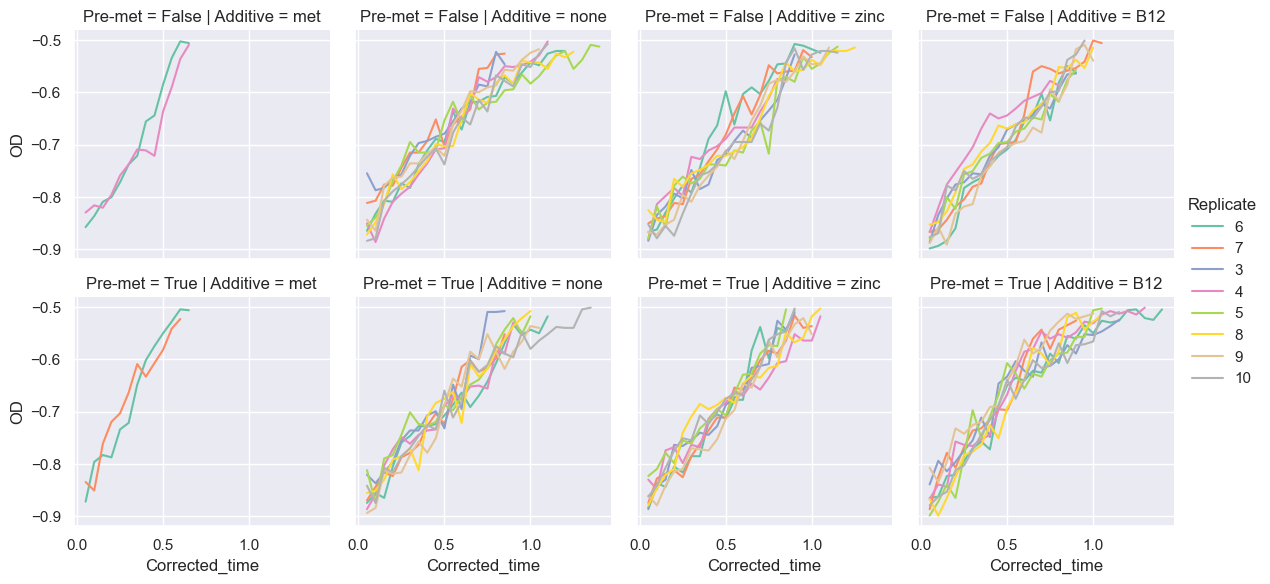

In [21]:
sns.relplot(x="Corrected_time", y="OD", hue="Replicate", kind="line", col="Additive", row="Pre-met", height=3, \
            data=gr_time_filter.filter( (pl.col("Time") < 10) & (pl.col("Time") > 0) ))

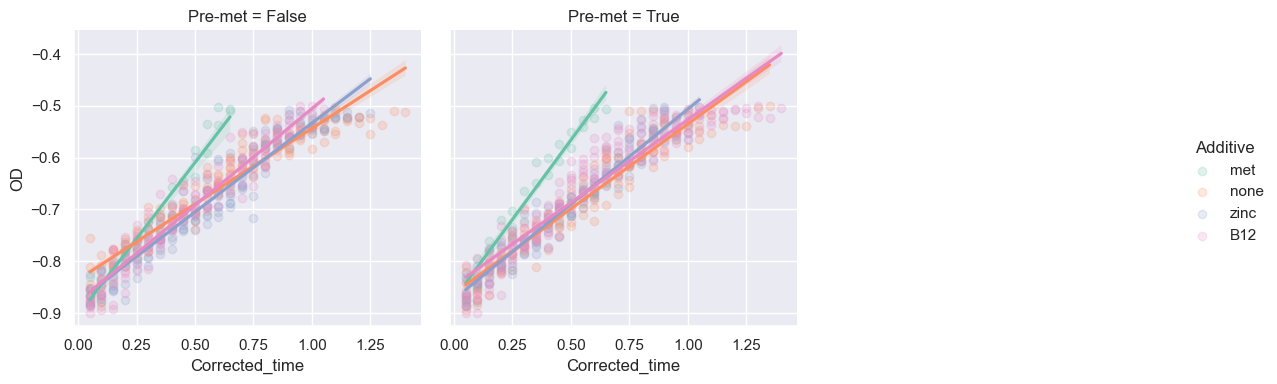

In [22]:
sns.lmplot(x="Corrected_time", y="OD", hue="Additive", col="Pre-met", col_wrap=3, height=4, 
           data=gr_time_filter.to_pandas(), scatter_kws = {"alpha": 0.2})

# All plates at once:

In [23]:
# plate 1
df = pl.read_csv("growth_data/adrian_growth_jan25_v2.csv")
df = df.drop('T600')

# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(3600 * df['Time'].dt.hour().cast(pl.Int64) + 60 * df['Time'].dt.minute().cast(pl.Int64) + df['Time'].dt.second())

# zero by first measurement
df = df.with_columns([pl.col(c) - df[0, c] for c in df.columns])

# melt to experiments
df = df.melt(id_vars="Time", variable_name="Well", value_name="OD")
df = df.with_columns((df["Well"].str.slice(0,1)).alias("Experiment"))
df = df.with_columns((df["Well"].str.slice(1)).alias("Replicate"))
df = df.with_columns(Plate = pl.lit("Plate 1"))

# plate 1
df2 = pl.read_csv("growth_data/cyrus_012624.csv")
df2 = df2.drop('T600')

# time conversion
df2 = df2.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df2 = df2.with_columns(3600 * df2['Time'].dt.hour().cast(pl.Int64) + 60 * df2['Time'].dt.minute().cast(pl.Int64) + df2['Time'].dt.second())

# zero by first measurement
df2 = df2.with_columns([pl.col(c) - df2[0, c] for c in df2.columns])

# melt to experiments
df2 = df2.melt(id_vars="Time", variable_name="Well", value_name="OD")
df2 = df2.with_columns((df2["Well"].str.slice(0,1)).alias("Experiment"))
df2 = df2.with_columns((df2["Well"].str.slice(1)).alias("Replicate"))
df2 = df2.with_columns(Plate = pl.lit("Plate 2"))

df = pl.concat([df, df2])
df

shape: (29_312, 6)
┌───────┬──────┬────────┬────────────┬───────────┬─────────┐
│ Time  ┆ Well ┆ OD     ┆ Experiment ┆ Replicate ┆ Plate   │
│ ---   ┆ ---  ┆ ---    ┆ ---        ┆ ---       ┆ ---     │
│ i64   ┆ str  ┆ f64    ┆ str        ┆ str       ┆ str     │
╞═══════╪══════╪════════╪════════════╪═══════════╪═════════╡
│ 0     ┆ A2   ┆ 0.0    ┆ A          ┆ 2         ┆ Plate 1 │
│ 300   ┆ A2   ┆ -0.001 ┆ A          ┆ 2         ┆ Plate 1 │
│ 600   ┆ A2   ┆ 0.0    ┆ A          ┆ 2         ┆ Plate 1 │
│ 900   ┆ A2   ┆ 0.001  ┆ A          ┆ 2         ┆ Plate 1 │
│ 1200  ┆ A2   ┆ 0.0    ┆ A          ┆ 2         ┆ Plate 1 │
│ …     ┆ …    ┆ …      ┆ …          ┆ …         ┆ …       │
│ 42480 ┆ H10  ┆ 0.62   ┆ H          ┆ 10        ┆ Plate 2 │
│ 42660 ┆ H10  ┆ 0.622  ┆ H          ┆ 10        ┆ Plate 2 │
│ 42840 ┆ H10  ┆ 0.624  ┆ H          ┆ 10        ┆ Plate 2 │
│ 43020 ┆ H10  ┆ 0.628  ┆ H          ┆ 10        ┆ Plate 2 │
│ 43200 ┆ H10  ┆ 0.631  ┆ H          ┆ 10        ┆ Plate 2 │
└───────┴──────┴────────┴────────────┴───────────┴─────────┘

In [24]:
# join with experiment type
column_names = ["Experiment", "Abb", "Description", "Pre-met", "Additive"]
conversion = [["A", "Rrm", "Rich + met, ++met", True, "met"], 
              ["B", "Rr", "Rich - met, ++met", True, "none"], 
              ["C", "RrZ", "Rich - met + Zn, ++met", True, "zinc"], 
              ["D", "Rrb", "Rich - met + B12, ++met", True, "B12"],
              ["E", "rm", "Rich + met, --met", False, "met"],
              ["F", "r", "Rich - met, --met", False, "none"],
              ["G", "rz", "Rich - met, --met", False, "zinc"],
              ["H", "rb", "Rich - met, --met", False, "B12"]]

exp = pl.DataFrame(conversion)
exp.columns = column_names


In [25]:
mdf = df.join(exp, on="Experiment")

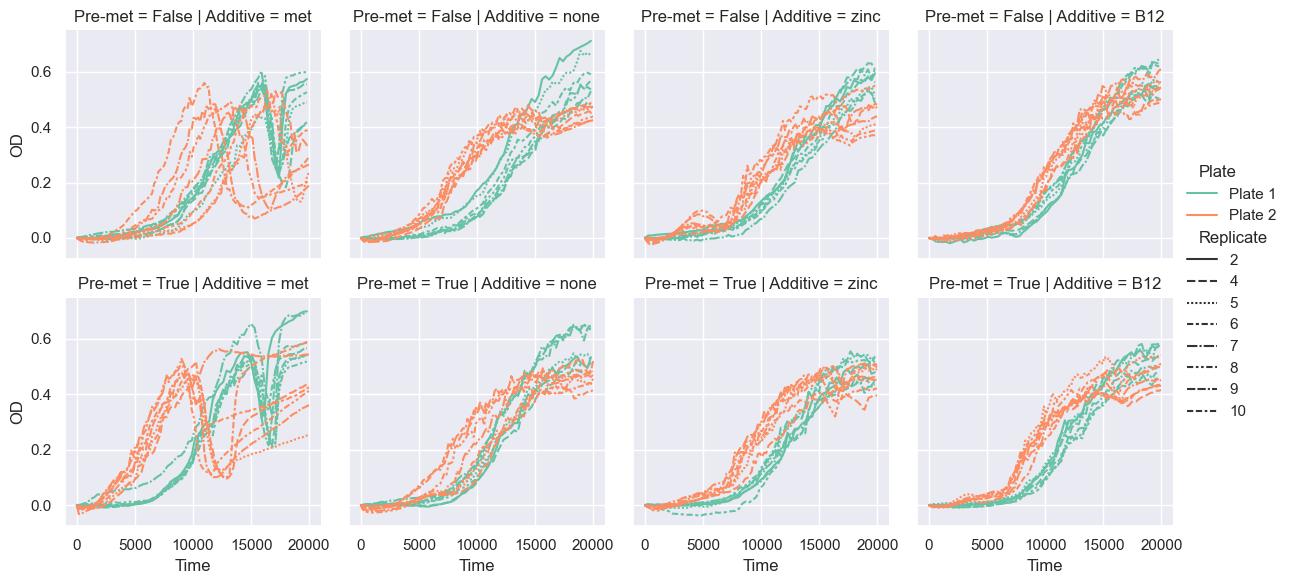

In [26]:
sns.relplot(x="Time", y="OD", hue="Plate", style="Replicate", kind="line", row="Pre-met", col="Additive", height=3, \
            data=mdf.filter(
                (pl.col("Time")<20000) & 
                (pl.col("Replicate") != "3")
           ))

In [27]:
growth_rate_precise = data=mdf.filter(
                (pl.col("Time")<40000) 
           )

growth_rate_precise = growth_rate_precise.with_columns(pl.concat_str([pl.col("Well"), pl.col("Plate")], separator=",").alias("Unique_well"))

minimum_start_times = growth_rate_precise.filter(pl.col("OD") <= 0.08).group_by("Unique_well").agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = growth_rate_precise.filter(pl.col("OD") >= 0.35).group_by("Unique_well").agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

growth_rate_precise = growth_rate_precise.join(minimum_start_times, on="Unique_well")
growth_rate_precise = growth_rate_precise.join(minimum_end_times, on="Unique_well")
gr_time_filter = growth_rate_precise.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_time_filter = gr_time_filter.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))

# correct all od values to start at 0
# start_od = gr_time_filter.group_by("Well").agg(pl.min("OD").alias("Start_OD")).sort("Start_OD")
# gr_time_filter = gr_time_filter.join(start_od, on="Well")
# gr_time_filter = gr_time_filter.with_columns((pl.col("OD") - pl.col("Start_OD")).alias("Corrected_OD"))

# correct by linear fit

#This is what you need
correction_offset = gr_time_filter.to_pandas().groupby('Unique_well').apply(regress, 'OD', ['Corrected_time'])
correction_offset = correction_offset.reset_index()
correction_offset = pl.DataFrame(correction_offset)

gr_time_filter = gr_time_filter.join(correction_offset, on="Unique_well")
gr_time_filter = gr_time_filter.with_columns((pl.col("OD") - pl.col("intercept")).alias("Corrected_OD"))

gr_time_filter

shape: (2_490, 17)
┌───────┬──────┬───────┬────────────┬───┬───────────────┬───────────────┬───────────┬──────────────┐
│ Time  ┆ Well ┆ OD    ┆ Experiment ┆ … ┆ Corrected_tim ┆ Corrected_tim ┆ intercept ┆ Corrected_OD │
│ ---   ┆ ---  ┆ ---   ┆ ---        ┆   ┆ e             ┆ e_right       ┆ ---       ┆ ---          │
│ i64   ┆ str  ┆ f64   ┆ str        ┆   ┆ ---           ┆ ---           ┆ f64       ┆ f64          │
│       ┆      ┆       ┆            ┆   ┆ i64           ┆ f64           ┆           ┆              │
╞═══════╪══════╪═══════╪════════════╪═══╪═══════════════╪═══════════════╪═══════════╪══════════════╡
│ 8100  ┆ A2   ┆ 0.083 ┆ A          ┆ … ┆ 300           ┆ 0.000076      ┆ 0.037303  ┆ 0.045697     │
│ 8400  ┆ A2   ┆ 0.094 ┆ A          ┆ … ┆ 600           ┆ 0.000076      ┆ 0.037303  ┆ 0.056697     │
│ 8700  ┆ A2   ┆ 0.101 ┆ A          ┆ … ┆ 900           ┆ 0.000076      ┆ 0.037303  ┆ 0.063697     │
│ 9000  ┆ A2   ┆ 0.113 ┆ A          ┆ … ┆ 1200          ┆ 0.000076      ┆ 0.037303  ┆ 0.075697     │
│ 9300  ┆ A2   ┆ 0.131 ┆ A          ┆ … ┆ 1500          ┆ 0.000076      ┆ 0.037303  ┆ 0.093697     │
│ …     ┆ …    ┆ …     ┆ …          ┆ … ┆ …             ┆ …             ┆ …         ┆ …            │
│ 12240 ┆ H10  ┆ 0.312 ┆ H          ┆ … ┆ 3960          ┆ 0.000058      ┆ 0.079652  ┆ 0.232348     │
│ 12420 ┆ H10  ┆ 0.311 ┆ H          ┆ … ┆ 4140          ┆ 0.000058      ┆ 0.079652  ┆ 0.231348     │
│ 12600 ┆ H10  ┆ 0.323 ┆ H          ┆ … ┆ 4320          ┆ 0.000058      ┆ 0.079652  ┆ 0.243348     │
│ 12780 ┆ H10  ┆ 0.338 ┆ H          ┆ … ┆ 4500          ┆ 0.000058      ┆ 0.079652  ┆ 0.258348     │
│ 12960 ┆ H10  ┆ 0.339 ┆ H          ┆ … ┆ 4680          ┆ 0.000058      ┆ 0.079652  ┆ 0.259348     │
└───────┴──────┴───────┴────────────┴───┴───────────────┴───────────────┴───────────┴──────────────┘

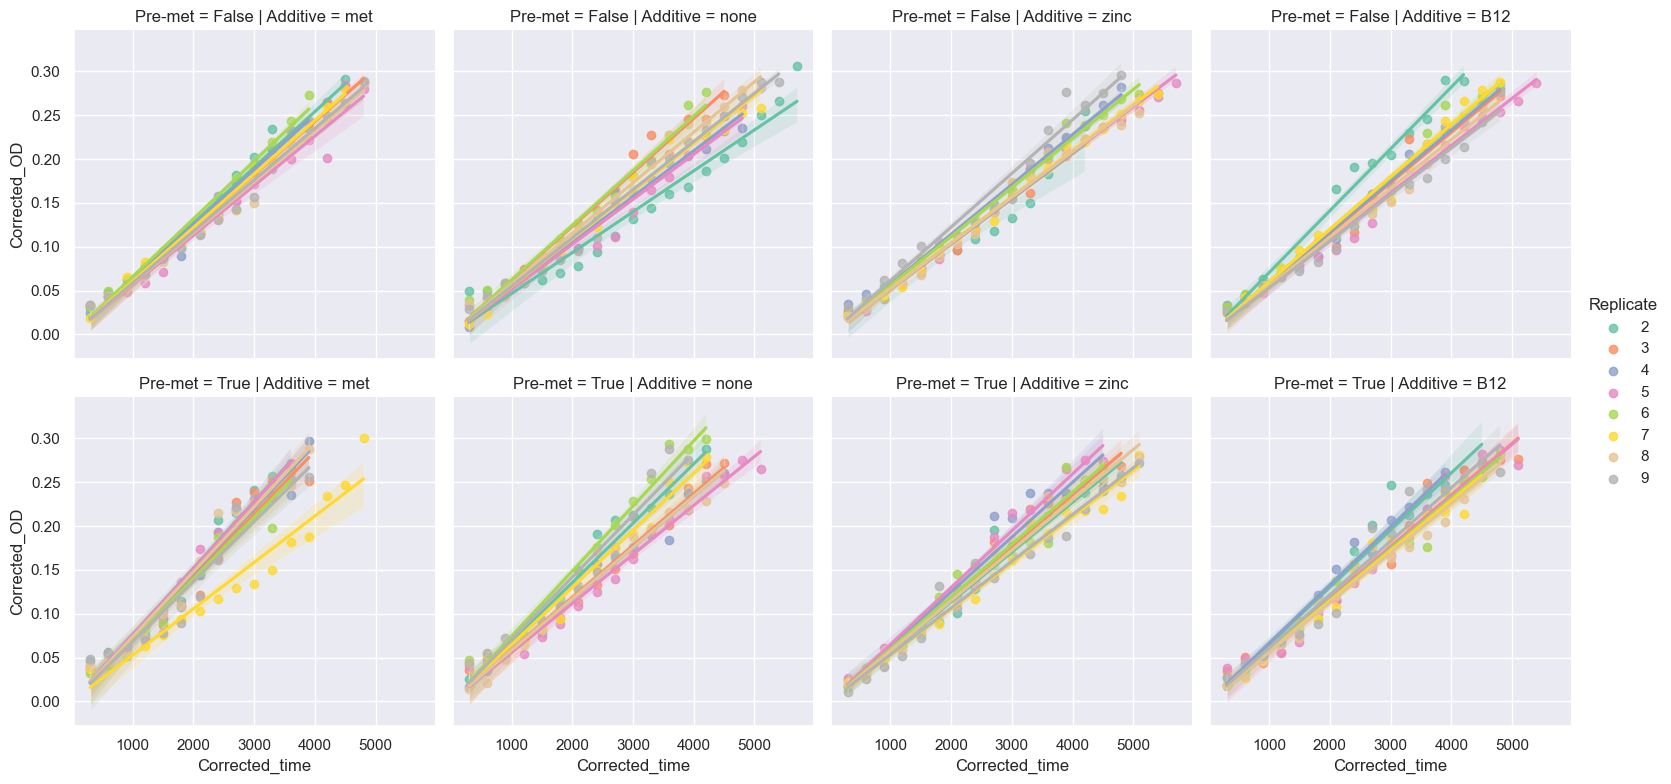

In [28]:
sns.lmplot(x="Corrected_time", y="Corrected_OD", hue="Replicate", col="Additive", row="Pre-met", height=4,
           data=gr_time_filter.filter((pl.col("Plate") == "Plate 1")).to_pandas())

In [29]:
predicted_gr = gr_time_filter.filter((pl.col("Plate") == "Plate 1") & (pl.col("Pre-met") == False)).to_pandas().groupby(['Additive', 'Plate', 'Pre-met']).apply(regress_error, 'Corrected_OD', ['Corrected_time'])
predicted_gr = predicted_gr.reset_index()

predicted_gr

Additive    Plate  Pre-met     slope  intercept       slope_e  intercept_e
0      B12  Plate 1    False  0.000057   0.002491  1.098559e-06     0.003204
1      met  Plate 1    False  0.000060   0.001704  9.004299e-07     0.002478
2     none  Plate 1    False  0.000053   0.003558  1.136756e-06     0.003435
3     zinc  Plate 1    False  0.000054   0.001121  8.148272e-07     0.002513

# Plate two

In [30]:
df = pl.read_csv("growth_data/cyrus_012624.csv")
df = df.drop('T600')
df

shape: (241, 65)
┌──────────┬───────┬───────┬───────┬───┬───────┬───────┬───────┬───────┐
│ Time     ┆ A3    ┆ A4    ┆ A5    ┆ … ┆ H7    ┆ H8    ┆ H9    ┆ H10   │
│ ---      ┆ ---   ┆ ---   ┆ ---   ┆   ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ str      ┆ f64   ┆ f64   ┆ f64   ┆   ┆ f64   ┆ f64   ┆ f64   ┆ f64   │
╞══════════╪═══════╪═══════╪═══════╪═══╪═══════╪═══════╪═══════╪═══════╡
│ 00:02:10 ┆ 0.232 ┆ 0.277 ┆ 0.25  ┆ … ┆ 0.11  ┆ 0.219 ┆ 0.195 ┆ 0.211 │
│ 00:05:10 ┆ 0.225 ┆ 0.267 ┆ 0.237 ┆ … ┆ 0.11  ┆ 0.218 ┆ 0.194 ┆ 0.21  │
│ 00:08:10 ┆ 0.225 ┆ 0.265 ┆ 0.237 ┆ … ┆ 0.109 ┆ 0.218 ┆ 0.195 ┆ 0.209 │
│ 00:11:10 ┆ 0.224 ┆ 0.264 ┆ 0.237 ┆ … ┆ 0.117 ┆ 0.218 ┆ 0.194 ┆ 0.209 │
│ 00:14:10 ┆ 0.224 ┆ 0.264 ┆ 0.236 ┆ … ┆ 0.112 ┆ 0.219 ┆ 0.194 ┆ 0.209 │
│ …        ┆ …     ┆ …     ┆ …     ┆ … ┆ …     ┆ …     ┆ …     ┆ …     │
│ 11:50:10 ┆ 0.957 ┆ 0.948 ┆ 0.632 ┆ … ┆ 0.68  ┆ 0.681 ┆ 0.761 ┆ 0.831 │
│ 11:53:10 ┆ 0.953 ┆ 0.946 ┆ 0.633 ┆ … ┆ 0.683 ┆ 0.68  ┆ 0.764 ┆ 0.833 │
│ 11:56:10 ┆ 0.953 ┆ 0.946 ┆ 0.633 ┆ … ┆ 0.684 ┆ 0.68  ┆ 0.767 ┆ 0.835 │
│ 11:59:10 ┆ 0.956 ┆ 0.949 ┆ 0.633 ┆ … ┆ 0.686 ┆ 0.679 ┆ 0.769 ┆ 0.839 │
│ 12:02:10 ┆ 0.956 ┆ 0.949 ┆ 0.634 ┆ … ┆ 0.687 ┆ 0.679 ┆ 0.771 ┆ 0.842 │
└──────────┴───────┴───────┴───────┴───┴───────┴───────┴───────┴───────┘

In [31]:
bf = pl.read_csv("growth_data/cyrus_012624_blanks.csv")
bf = bf.drop('T600')
bfm = bf.mean()
bfm[0, "Time"] = 0
bfm = bfm.with_columns(bfm["Time"].cast(pl.Int64))

In [32]:
df = pl.read_csv("growth_data/cyrus_012624.csv")
df = df.drop('T600')
df

# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(3600 * df['Time'].dt.hour().cast(pl.Int64) + 60 * df['Time'].dt.minute().cast(pl.Int64) + df['Time'].dt.second())

# zero by first measurement
df = df.with_columns([pl.col(c) - df[0, c] for c in df.columns])

# melt to experiments
df = df.melt(id_vars="Time", variable_name="Well", value_name="OD")
df = df.with_columns((df["Well"].str.slice(0,1)).alias("Experiment"))
df = df.with_columns((df["Well"].str.slice(1)).alias("Replicate"))
df

df

shape: (15_424, 5)
┌───────┬──────┬────────┬────────────┬───────────┐
│ Time  ┆ Well ┆ OD     ┆ Experiment ┆ Replicate │
│ ---   ┆ ---  ┆ ---    ┆ ---        ┆ ---       │
│ i64   ┆ str  ┆ f64    ┆ str        ┆ str       │
╞═══════╪══════╪════════╪════════════╪═══════════╡
│ 0     ┆ A3   ┆ 0.0    ┆ A          ┆ 3         │
│ 180   ┆ A3   ┆ -0.007 ┆ A          ┆ 3         │
│ 360   ┆ A3   ┆ -0.007 ┆ A          ┆ 3         │
│ 540   ┆ A3   ┆ -0.008 ┆ A          ┆ 3         │
│ 720   ┆ A3   ┆ -0.008 ┆ A          ┆ 3         │
│ …     ┆ …    ┆ …      ┆ …          ┆ …         │
│ 42480 ┆ H10  ┆ 0.62   ┆ H          ┆ 10        │
│ 42660 ┆ H10  ┆ 0.622  ┆ H          ┆ 10        │
│ 42840 ┆ H10  ┆ 0.624  ┆ H          ┆ 10        │
│ 43020 ┆ H10  ┆ 0.628  ┆ H          ┆ 10        │
│ 43200 ┆ H10  ┆ 0.631  ┆ H          ┆ 10        │
└───────┴──────┴────────┴────────────┴───────────┘

In [33]:
# join with experiment type
column_names = ["Experiment", "Abb", "Description", "Pre-met", "Additive"]
conversion = [["A", "Rrm", "Rich + met, ++met", True, "met"], 
              ["B", "Rr", "Rich - met, ++met", True, "none"], 
              ["C", "RrZ", "Rich - met + Zn, ++met", True, "zinc"], 
              ["D", "Rrb", "Rich - met + B12, ++met", True, "B12"],
              ["E", "rm", "Rich + met, --met", False, "met"],
              ["F", "r", "Rich - met, --met", False, "none"],
              ["G", "rz", "Rich - met, --met", False, "zinc"],
              ["H", "rb", "Rich - met, --met", False, "B12"]]

exp = pl.DataFrame(conversion)
exp.columns = column_names

exp

shape: (8, 5)
┌────────────┬─────┬─────────────────────────┬─────────┬──────────┐
│ Experiment ┆ Abb ┆ Description             ┆ Pre-met ┆ Additive │
│ ---        ┆ --- ┆ ---                     ┆ ---     ┆ ---      │
│ str        ┆ str ┆ str                     ┆ bool    ┆ str      │
╞════════════╪═════╪═════════════════════════╪═════════╪══════════╡
│ A          ┆ Rrm ┆ Rich + met, ++met       ┆ true    ┆ met      │
│ B          ┆ Rr  ┆ Rich - met, ++met       ┆ true    ┆ none     │
│ C          ┆ RrZ ┆ Rich - met + Zn, ++met  ┆ true    ┆ zinc     │
│ D          ┆ Rrb ┆ Rich - met + B12, ++met ┆ true    ┆ B12      │
│ E          ┆ rm  ┆ Rich + met, --met       ┆ false   ┆ met      │
│ F          ┆ r   ┆ Rich - met, --met       ┆ false   ┆ none     │
│ G          ┆ rz  ┆ Rich - met, --met       ┆ false   ┆ zinc     │
│ H          ┆ rb  ┆ Rich - met, --met       ┆ false   ┆ B12      │
└────────────┴─────┴─────────────────────────┴─────────┴──────────┘

In [34]:
mdf = df.join(exp, on="Experiment")

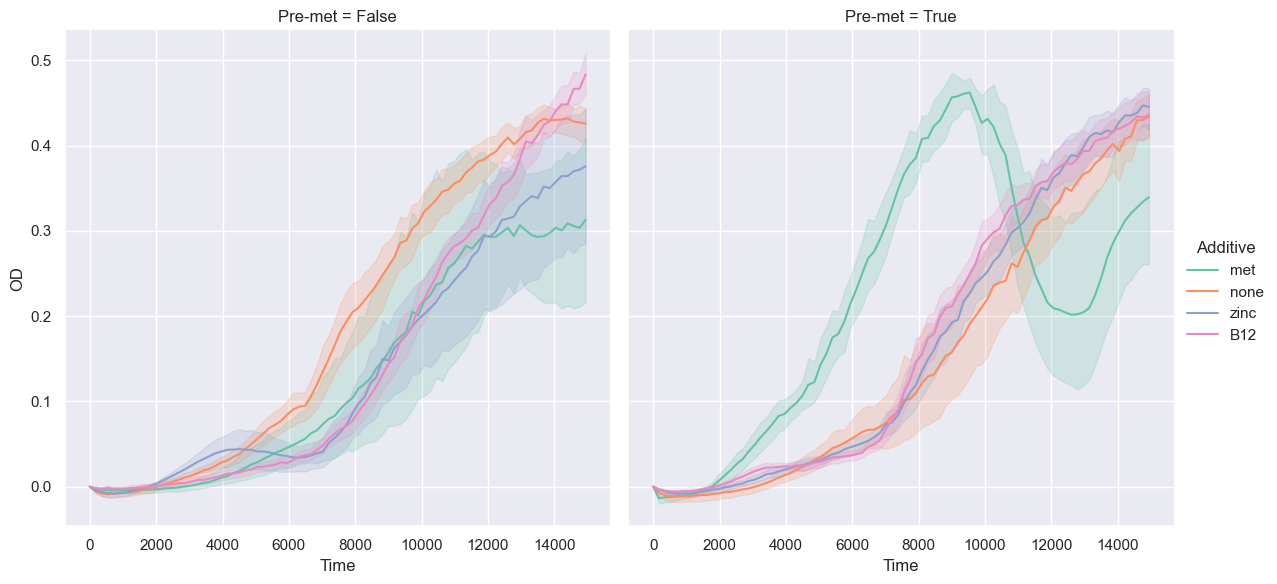

In [35]:
sns.relplot(x="Time", y="OD", kind="line",  hue="Additive", col="Pre-met", height=6, col_wrap=2, data=mdf.filter(pl.col("Time")<15000))

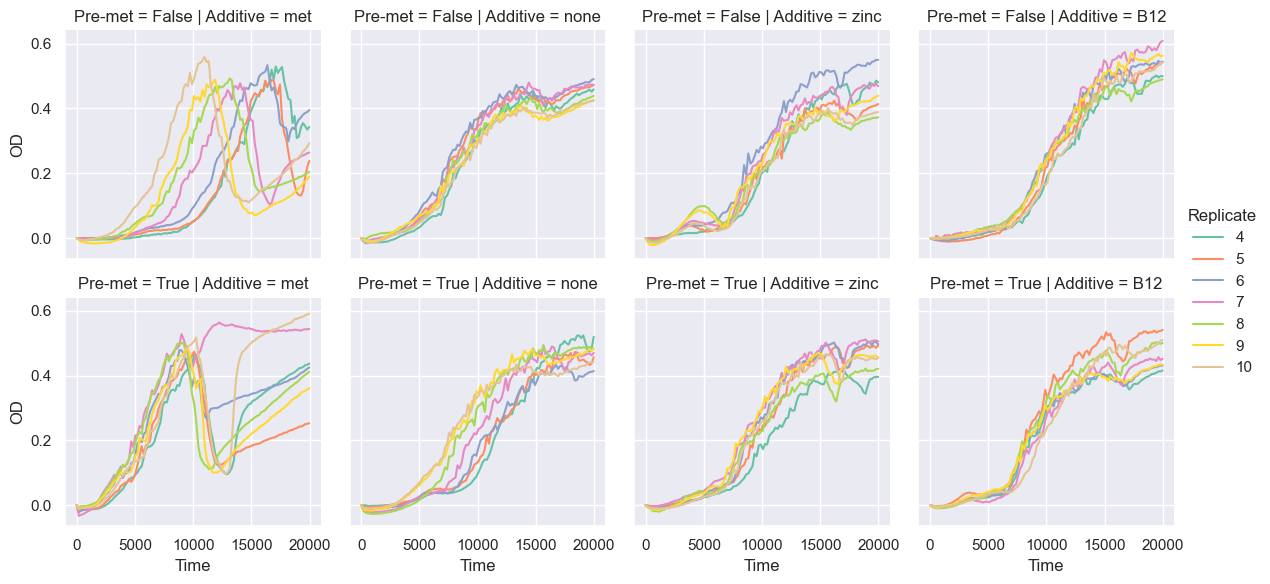

In [36]:
sns.relplot(x="Time", y="OD", hue="Replicate", kind="line", row="Pre-met", col="Additive", height=3, \
            data=mdf.filter(
                (pl.col("Time")<20000) & 
                (pl.col("Replicate") != "3")
           ))

In [37]:
growth_rate_precise = data=mdf.filter(
                (pl.col("Time")<20000) 
           )


minimum_start_times = growth_rate_precise.filter(pl.col("OD") <= 0.06).group_by("Well").agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = growth_rate_precise.filter(pl.col("OD") >= 0.30).group_by("Well").agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

growth_rate_precise = growth_rate_precise.join(minimum_start_times, on="Well")
growth_rate_precise = growth_rate_precise.join(minimum_end_times, on="Well")
gr_time_filter = growth_rate_precise.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_time_filter = gr_time_filter.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))

# correct all od values to start at 0
# start_od = gr_time_filter.group_by("Well").agg(pl.min("OD").alias("Start_OD")).sort("Start_OD")
# gr_time_filter = gr_time_filter.join(start_od, on="Well")
# gr_time_filter = gr_time_filter.with_columns((pl.col("OD") - pl.col("Start_OD")).alias("Corrected_OD"))

# correct by linear fit

#This is what you need
correction_offset = gr_time_filter.to_pandas().groupby('Well').apply(regress, 'OD', ['Corrected_time'])
correction_offset = correction_offset.reset_index()
correction_offset = pl.DataFrame(correction_offset)

gr_time_filter = gr_time_filter.join(correction_offset, on="Well")
gr_time_filter = gr_time_filter.with_columns((pl.col("OD") - pl.col("intercept")).alias("Corrected_OD"))

gr_time_filter

shape: (1_388, 15)
┌───────┬──────┬───────┬────────────┬───┬───────────────┬───────────────┬───────────┬──────────────┐
│ Time  ┆ Well ┆ OD    ┆ Experiment ┆ … ┆ Corrected_tim ┆ Corrected_tim ┆ intercept ┆ Corrected_OD │
│ ---   ┆ ---  ┆ ---   ┆ ---        ┆   ┆ e             ┆ e_right       ┆ ---       ┆ ---          │
│ i64   ┆ str  ┆ f64   ┆ str        ┆   ┆ ---           ┆ ---           ┆ f64       ┆ f64          │
│       ┆      ┆       ┆            ┆   ┆ i64           ┆ f64           ┆           ┆              │
╞═══════╪══════╪═══════╪════════════╪═══╪═══════════════╪═══════════════╪═══════════╪══════════════╡
│ 4140  ┆ A3   ┆ 0.066 ┆ A          ┆ … ┆ 180           ┆ 0.000069      ┆ 0.032632  ┆ 0.033368     │
│ 4320  ┆ A3   ┆ 0.075 ┆ A          ┆ … ┆ 360           ┆ 0.000069      ┆ 0.032632  ┆ 0.042368     │
│ 4500  ┆ A3   ┆ 0.085 ┆ A          ┆ … ┆ 540           ┆ 0.000069      ┆ 0.032632  ┆ 0.052368     │
│ 4680  ┆ A3   ┆ 0.082 ┆ A          ┆ … ┆ 720           ┆ 0.000069      ┆ 0.032632  ┆ 0.049368     │
│ 4860  ┆ A3   ┆ 0.087 ┆ A          ┆ … ┆ 900           ┆ 0.000069      ┆ 0.032632  ┆ 0.054368     │
│ …     ┆ …    ┆ …     ┆ …          ┆ … ┆ …             ┆ …             ┆ …         ┆ …            │
│ 11160 ┆ H10  ┆ 0.254 ┆ H          ┆ … ┆ 3420          ┆ 0.00006       ┆ 0.046715  ┆ 0.207285     │
│ 11340 ┆ H10  ┆ 0.258 ┆ H          ┆ … ┆ 3600          ┆ 0.00006       ┆ 0.046715  ┆ 0.211285     │
│ 11520 ┆ H10  ┆ 0.27  ┆ H          ┆ … ┆ 3780          ┆ 0.00006       ┆ 0.046715  ┆ 0.223285     │
│ 11700 ┆ H10  ┆ 0.276 ┆ H          ┆ … ┆ 3960          ┆ 0.00006       ┆ 0.046715  ┆ 0.229285     │
│ 11880 ┆ H10  ┆ 0.283 ┆ H          ┆ … ┆ 4140          ┆ 0.00006       ┆ 0.046715  ┆ 0.236285     │
└───────┴──────┴───────┴────────────┴───┴───────────────┴───────────────┴───────────┴──────────────┘

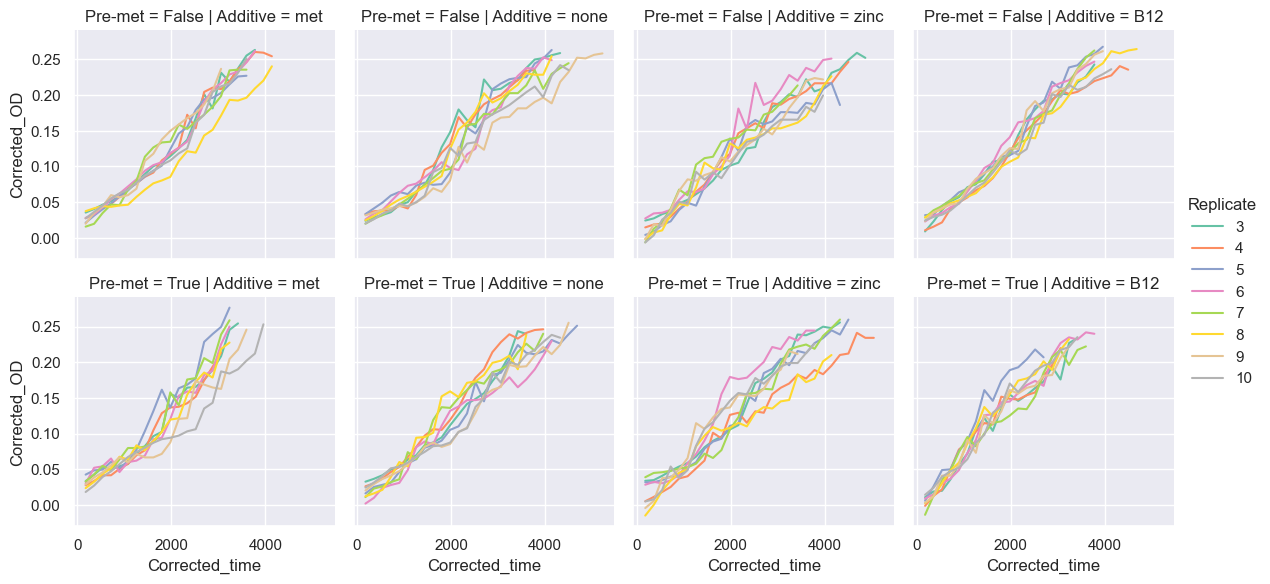

In [38]:
sns.relplot(x="Corrected_time", y="Corrected_OD", hue="Replicate", kind="line", row="Pre-met", col="Additive", height=3, \
            data=gr_time_filter)

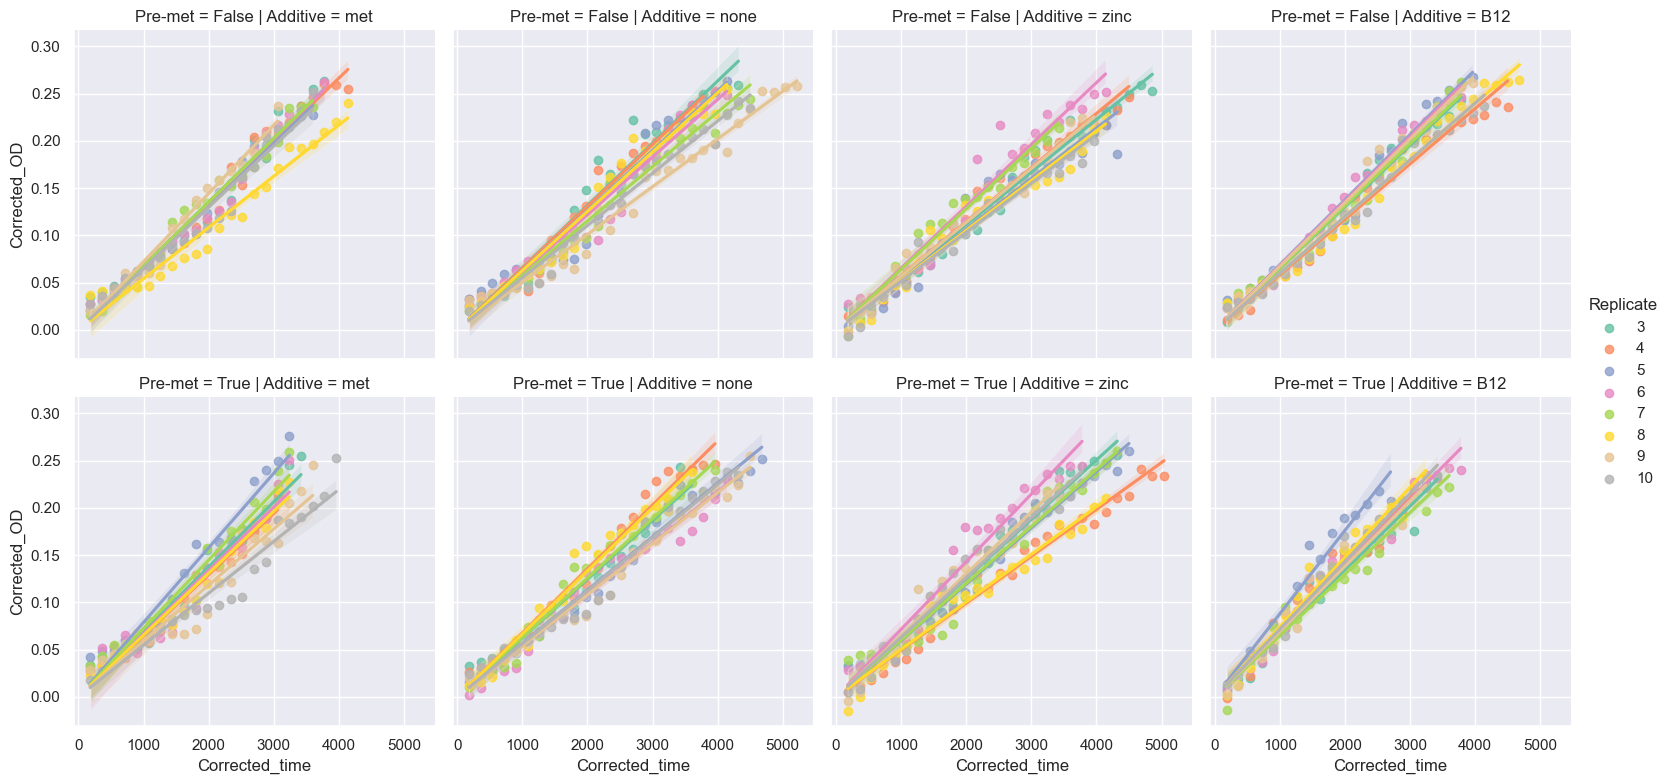

In [39]:
sns.lmplot(x="Corrected_time", y="Corrected_OD", hue="Replicate", col="Additive", row="Pre-met", height=4,data=gr_time_filter.to_pandas())

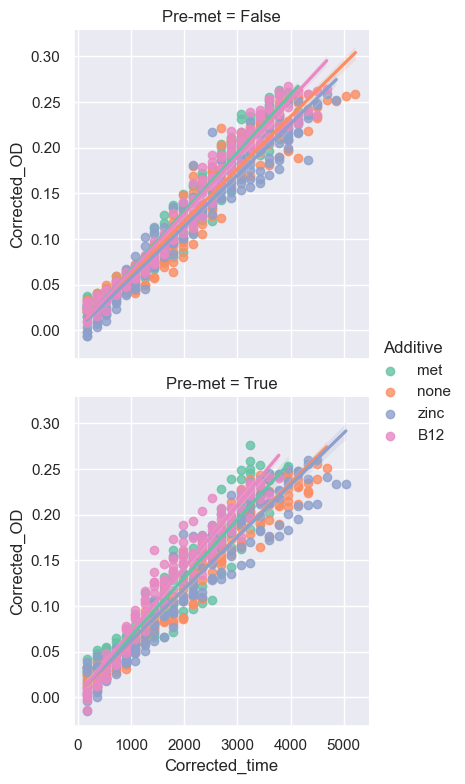

In [40]:
sns.lmplot(x="Corrected_time", y="Corrected_OD", hue="Additive", row="Pre-met", height=4,data=gr_time_filter.to_pandas())

In [41]:
predicted_gr = gr_time_filter.to_pandas().groupby('Additive').apply(regress_error, 'Corrected_OD', ['Corrected_time'])
predicted_gr = predicted_gr.reset_index()

predicted_gr

Additive     slope  intercept       slope_e  intercept_e
0      B12  0.000064   0.005133  8.400059e-07     0.001903
1      met  0.000064   0.002766  1.026165e-06     0.002208
2     none  0.000058   0.003657  7.807927e-07     0.001988
3     zinc  0.000057   0.003028  8.443688e-07     0.002128

# 2nd round, different overnight media +/- met

In [42]:
bf = pl.read_csv("growth_data/adrian_growth_jan25_blanks.csv")
bf = bf.drop('T� 600')
bfm = bf.mean()
bfm[0, "Time"] = 0
bfm = bfm.with_columns(bfm["Time"].cast(pl.Int64))

In [43]:
df = pl.read_csv("growth_data/adrian_growth_jan25_v2.csv")
df = df.drop('T∞ 600')
df

shape: (217, 66)
┌──────────┬──────┬───────┬───────┬───┬───────┬───────┬───────┬───────┐
│ Time     ┆ T600 ┆ A2    ┆ A3    ┆ … ┆ H6    ┆ H7    ┆ H8    ┆ H9    │
│ ---      ┆ ---  ┆ ---   ┆ ---   ┆   ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ str      ┆ f64  ┆ f64   ┆ f64   ┆   ┆ f64   ┆ f64   ┆ f64   ┆ f64   │
╞══════════╪══════╪═══════╪═══════╪═══╪═══════╪═══════╪═══════╪═══════╡
│ 00:04:10 ┆ 36.9 ┆ 0.924 ┆ 0.844 ┆ … ┆ 0.786 ┆ 0.768 ┆ 0.883 ┆ 0.938 │
│ 00:09:10 ┆ 37.1 ┆ 0.923 ┆ 0.842 ┆ … ┆ 0.784 ┆ 0.768 ┆ 0.881 ┆ 0.936 │
│ 00:14:10 ┆ 37.0 ┆ 0.924 ┆ 0.842 ┆ … ┆ 0.786 ┆ 0.768 ┆ 0.882 ┆ 0.935 │
│ 00:19:10 ┆ 37.0 ┆ 0.925 ┆ 0.84  ┆ … ┆ 0.785 ┆ 0.768 ┆ 0.882 ┆ 0.934 │
│ 00:24:10 ┆ 37.1 ┆ 0.924 ┆ 0.841 ┆ … ┆ 0.786 ┆ 0.768 ┆ 0.883 ┆ 0.936 │
│ …        ┆ …    ┆ …     ┆ …     ┆ … ┆ …     ┆ …     ┆ …     ┆ …     │
│ 17:44:10 ┆ 37.0 ┆ 1.946 ┆ 1.854 ┆ … ┆ 1.656 ┆ 1.671 ┆ 1.793 ┆ 1.758 │
│ 17:49:10 ┆ 37.0 ┆ 1.949 ┆ 1.859 ┆ … ┆ 1.659 ┆ 1.671 ┆ 1.795 ┆ 1.761 │
│ 17:54:10 ┆ 37.0 ┆ 1.953 ┆ 1.861 ┆ … ┆ 1.664 ┆ 1.676 ┆ 1.798 ┆ 1.764 │
│ 17:59:10 ┆ 37.0 ┆ 1.955 ┆ 1.866 ┆ … ┆ 1.667 ┆ 1.679 ┆ 1.8   ┆ 1.769 │
│ 18:04:10 ┆ 37.0 ┆ 1.958 ┆ 1.868 ┆ … ┆ 1.668 ┆ 1.68  ┆ 1.803 ┆ 1.772 │
└──────────┴──────┴───────┴───────┴───┴───────┴───────┴───────┴───────┘

In [44]:
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(3600 * df['Time'].dt.hour().cast(pl.Int64) + 60 * df['Time'].dt.minute().cast(pl.Int64) + df['Time'].dt.second())

df

shape: (217, 66)
┌───────┬──────┬───────┬───────┬───┬───────┬───────┬───────┬───────┐
│ Time  ┆ T600 ┆ A2    ┆ A3    ┆ … ┆ H6    ┆ H7    ┆ H8    ┆ H9    │
│ ---   ┆ ---  ┆ ---   ┆ ---   ┆   ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ i64   ┆ f64  ┆ f64   ┆ f64   ┆   ┆ f64   ┆ f64   ┆ f64   ┆ f64   │
╞═══════╪══════╪═══════╪═══════╪═══╪═══════╪═══════╪═══════╪═══════╡
│ 250   ┆ 36.9 ┆ 0.924 ┆ 0.844 ┆ … ┆ 0.786 ┆ 0.768 ┆ 0.883 ┆ 0.938 │
│ 550   ┆ 37.1 ┆ 0.923 ┆ 0.842 ┆ … ┆ 0.784 ┆ 0.768 ┆ 0.881 ┆ 0.936 │
│ 850   ┆ 37.0 ┆ 0.924 ┆ 0.842 ┆ … ┆ 0.786 ┆ 0.768 ┆ 0.882 ┆ 0.935 │
│ 1150  ┆ 37.0 ┆ 0.925 ┆ 0.84  ┆ … ┆ 0.785 ┆ 0.768 ┆ 0.882 ┆ 0.934 │
│ 1450  ┆ 37.1 ┆ 0.924 ┆ 0.841 ┆ … ┆ 0.786 ┆ 0.768 ┆ 0.883 ┆ 0.936 │
│ …     ┆ …    ┆ …     ┆ …     ┆ … ┆ …     ┆ …     ┆ …     ┆ …     │
│ 63850 ┆ 37.0 ┆ 1.946 ┆ 1.854 ┆ … ┆ 1.656 ┆ 1.671 ┆ 1.793 ┆ 1.758 │
│ 64150 ┆ 37.0 ┆ 1.949 ┆ 1.859 ┆ … ┆ 1.659 ┆ 1.671 ┆ 1.795 ┆ 1.761 │
│ 64450 ┆ 37.0 ┆ 1.953 ┆ 1.861 ┆ … ┆ 1.664 ┆ 1.676 ┆ 1.798 ┆ 1.764 │
│ 64750 ┆ 37.0 ┆ 1.955 ┆ 1.866 ┆ … ┆ 1.667 ┆ 1.679 ┆ 1.8   ┆ 1.769 │
│ 65050 ┆ 37.0 ┆ 1.958 ┆ 1.868 ┆ … ┆ 1.668 ┆ 1.68  ┆ 1.803 ┆ 1.772 │
└───────┴──────┴───────┴───────┴───┴───────┴───────┴───────┴───────┘

In [45]:
df = df.with_columns([pl.col(c) - df[0, c] for c in df.columns])

In [46]:
df = df.melt(id_vars="Time", variable_name="Well", value_name="OD")
df = df.with_columns((df["Well"].str.slice(0,1)).alias("Experiment"))
df = df.with_columns((df["Well"].str.slice(1)).alias("Replicate"))
df

shape: (14_105, 5)
┌───────┬──────┬───────┬────────────┬───────────┐
│ Time  ┆ Well ┆ OD    ┆ Experiment ┆ Replicate │
│ ---   ┆ ---  ┆ ---   ┆ ---        ┆ ---       │
│ i64   ┆ str  ┆ f64   ┆ str        ┆ str       │
╞═══════╪══════╪═══════╪════════════╪═══════════╡
│ 0     ┆ T600 ┆ 0.0   ┆ T          ┆ 600       │
│ 300   ┆ T600 ┆ 0.2   ┆ T          ┆ 600       │
│ 600   ┆ T600 ┆ 0.1   ┆ T          ┆ 600       │
│ 900   ┆ T600 ┆ 0.1   ┆ T          ┆ 600       │
│ 1200  ┆ T600 ┆ 0.2   ┆ T          ┆ 600       │
│ …     ┆ …    ┆ …     ┆ …          ┆ …         │
│ 63600 ┆ H9   ┆ 0.82  ┆ H          ┆ 9         │
│ 63900 ┆ H9   ┆ 0.823 ┆ H          ┆ 9         │
│ 64200 ┆ H9   ┆ 0.826 ┆ H          ┆ 9         │
│ 64500 ┆ H9   ┆ 0.831 ┆ H          ┆ 9         │
│ 64800 ┆ H9   ┆ 0.834 ┆ H          ┆ 9         │
└───────┴──────┴───────┴────────────┴───────────┘

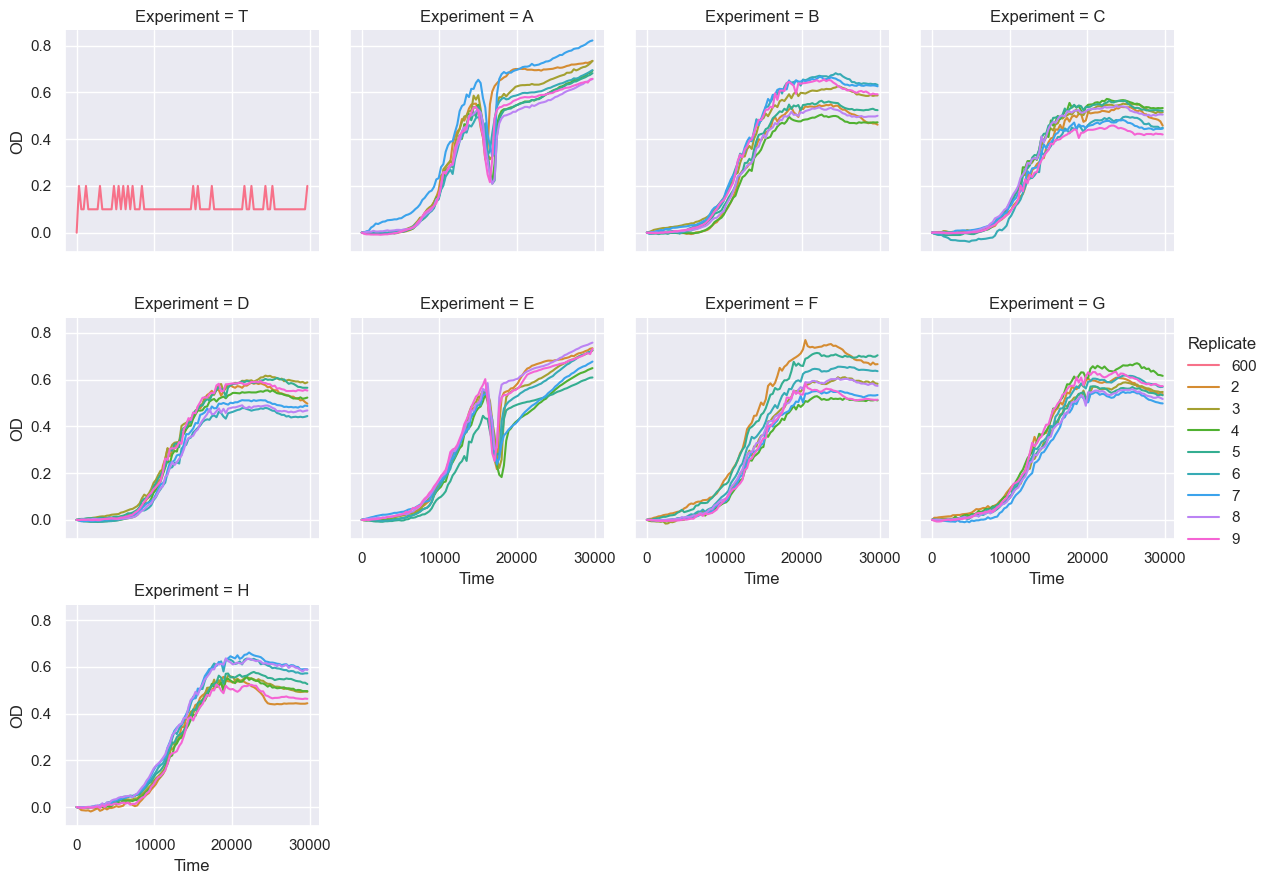

In [47]:
sns.relplot(x="Time", y="OD", hue="Replicate", kind="line", col="Experiment", col_wrap=4, height=3, data=df.filter(pl.col("Time")<30000))

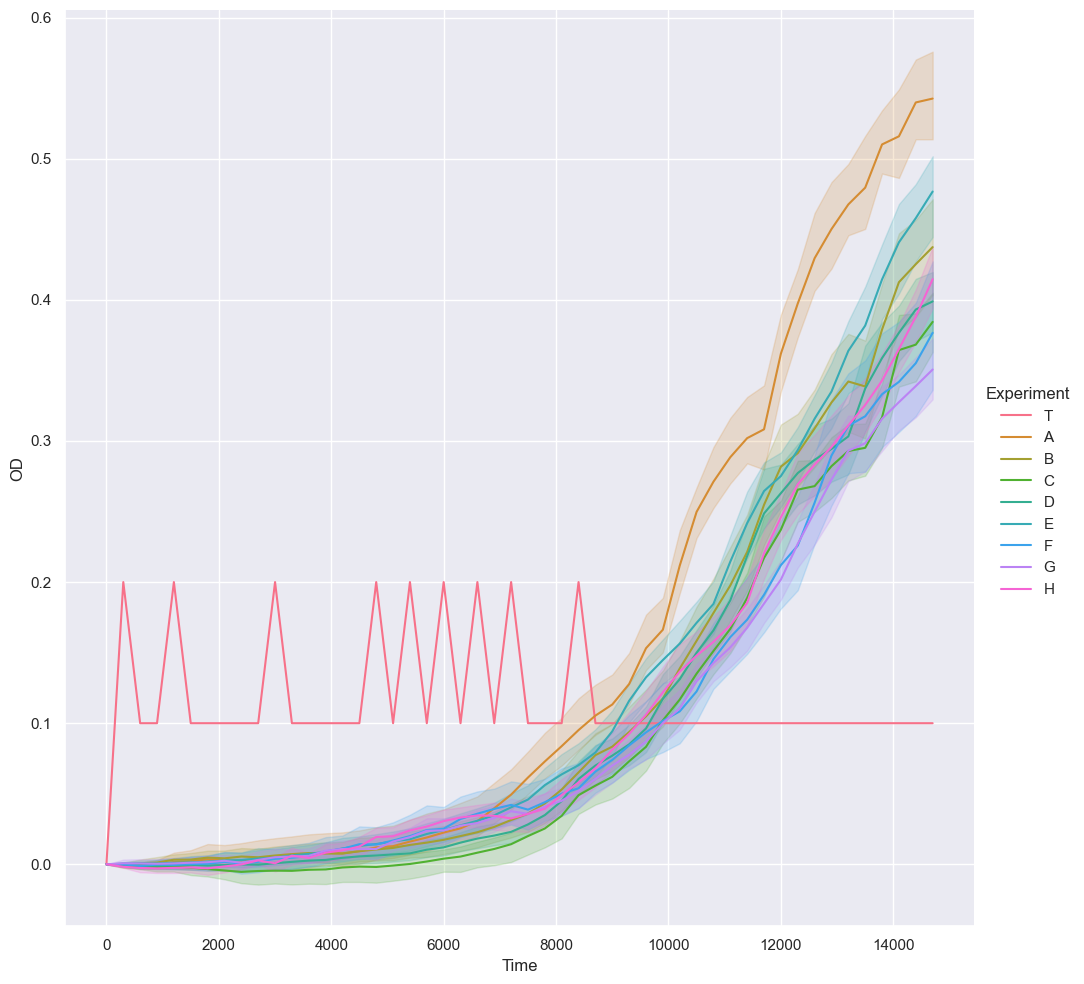

In [48]:
sns.relplot(x="Time", y="OD", hue="Experiment", kind="line", height=10, data=df.filter(pl.col("Time")<15000))

R	First overnight culture in rich + met (otherwise overnight was in media without met)

r	rich

m	met

z	with Zn

z	with B12

In [49]:
column_names = ["Experiment", "Abb", "Description", "Pre-met", "Additive"]
conversion = [["A", "Rrm", "Rich + met, ++met", True, "met"], 
              ["B", "Rr", "Rich - met, ++met", True, "none"], 
              ["C", "RrZ", "Rich - met + Zn, ++met", True, "zinc"], 
              ["D", "Rrb", "Rich - met + B12, ++met", True, "B12"],
              ["E", "rm", "Rich + met, --met", False, "met"],
              ["F", "r", "Rich - met, --met", False, "none"],
              ["G", "rz", "Rich - met, --met", False, "zinc"],
              ["H", "rb", "Rich - met, --met", False, "B12"]]

exp = pl.DataFrame(conversion)
exp.columns = column_names

exp

shape: (8, 5)
┌────────────┬─────┬─────────────────────────┬─────────┬──────────┐
│ Experiment ┆ Abb ┆ Description             ┆ Pre-met ┆ Additive │
│ ---        ┆ --- ┆ ---                     ┆ ---     ┆ ---      │
│ str        ┆ str ┆ str                     ┆ bool    ┆ str      │
╞════════════╪═════╪═════════════════════════╪═════════╪══════════╡
│ A          ┆ Rrm ┆ Rich + met, ++met       ┆ true    ┆ met      │
│ B          ┆ Rr  ┆ Rich - met, ++met       ┆ true    ┆ none     │
│ C          ┆ RrZ ┆ Rich - met + Zn, ++met  ┆ true    ┆ zinc     │
│ D          ┆ Rrb ┆ Rich - met + B12, ++met ┆ true    ┆ B12      │
│ E          ┆ rm  ┆ Rich + met, --met       ┆ false   ┆ met      │
│ F          ┆ r   ┆ Rich - met, --met       ┆ false   ┆ none     │
│ G          ┆ rz  ┆ Rich - met, --met       ┆ false   ┆ zinc     │
│ H          ┆ rb  ┆ Rich - met, --met       ┆ false   ┆ B12      │
└────────────┴─────┴─────────────────────────┴─────────┴──────────┘

In [50]:
mdf = df.join(exp, on="Experiment")

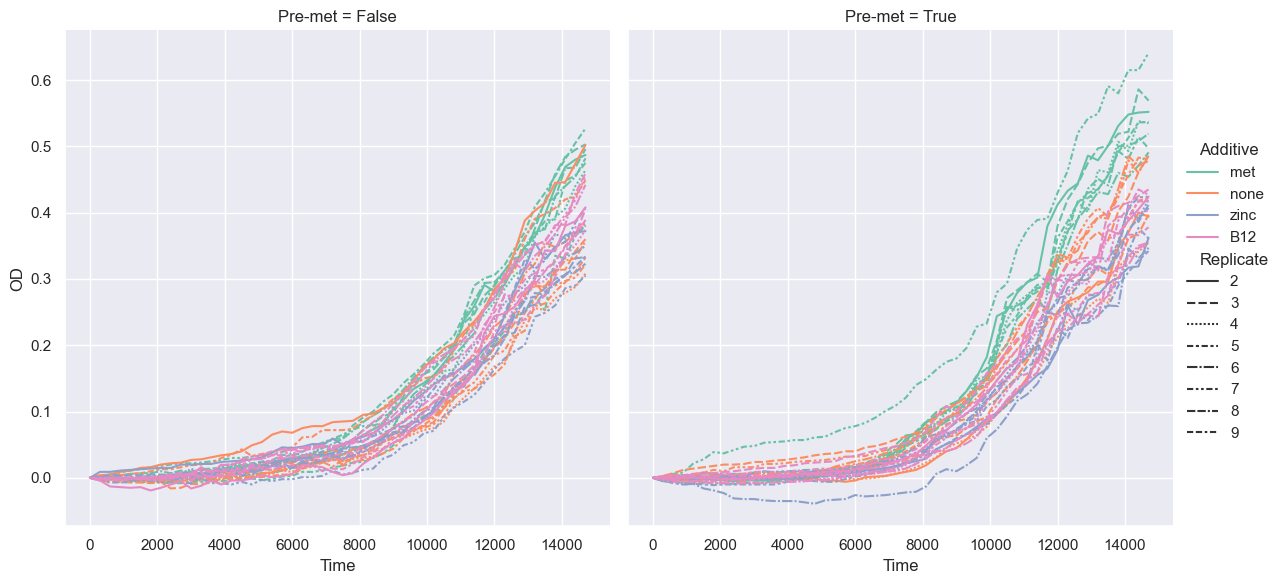

In [51]:
sns.relplot(x="Time", y="OD", kind="line", col="Pre-met", hue="Additive", style="Replicate", height=6, data=mdf.filter(pl.col("Time")<15000))

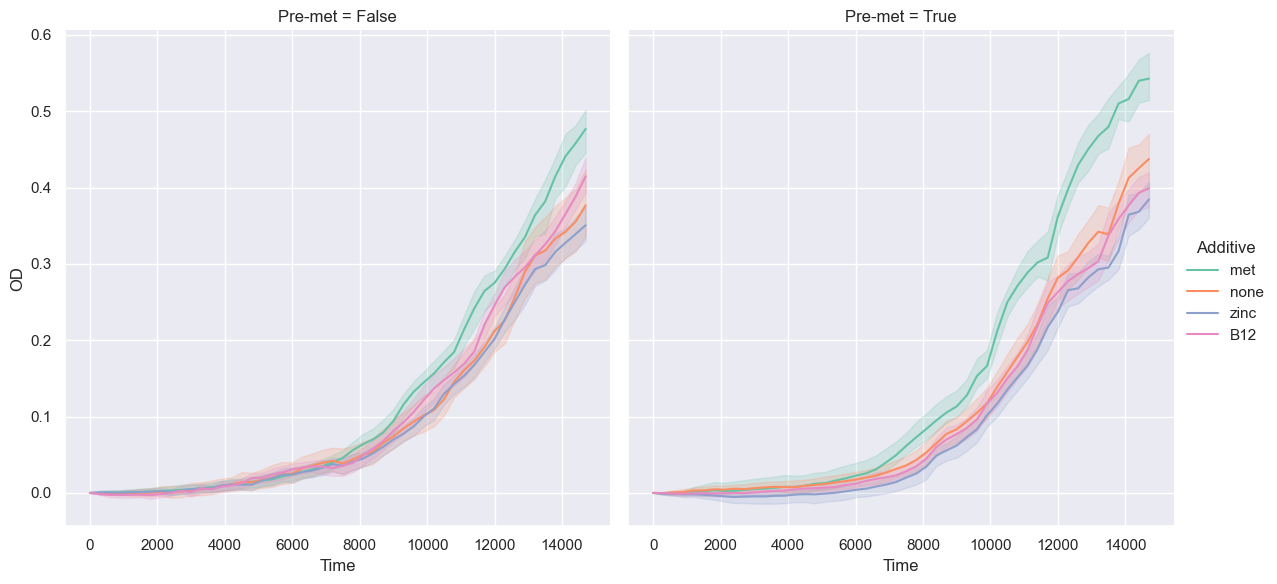

In [52]:
sns.relplot(x="Time", y="OD", kind="line",  hue="Additive", col="Pre-met", height=6, col_wrap=2, data=mdf.filter(pl.col("Time")<15000))

In [53]:
pdf = mdf.filter((pl.col("Time")<15000) & (pl.col("Time") > 10000)).to_pandas()

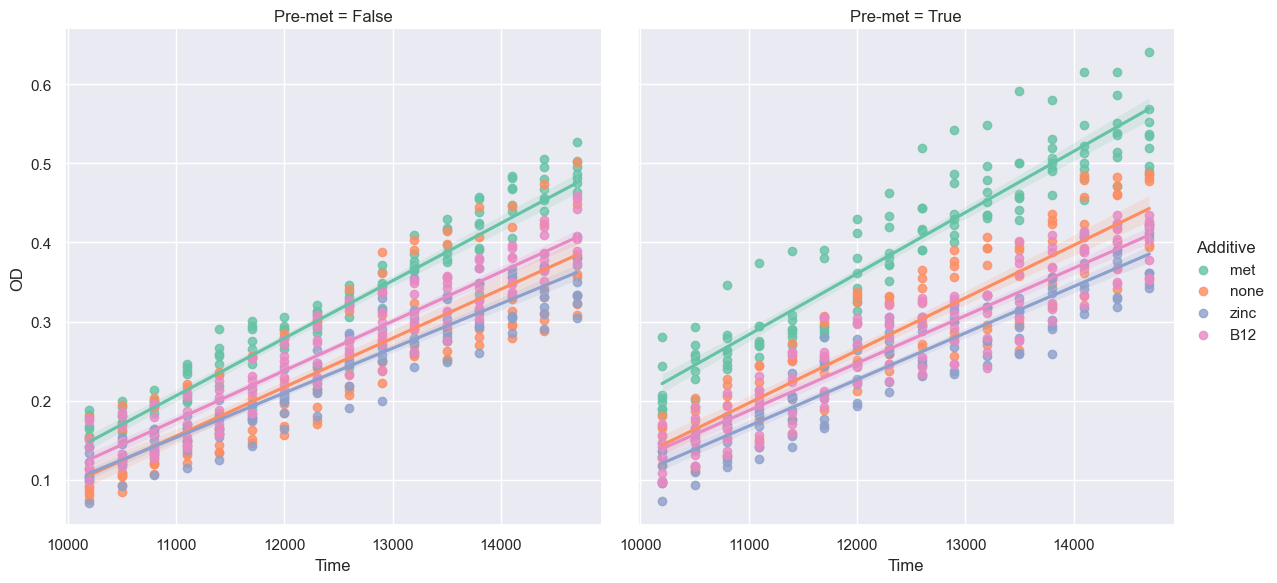

In [54]:
sns.lmplot(x="Time", y="OD", hue="Additive", col="Pre-met", height=6, col_wrap=2, data=pdf)

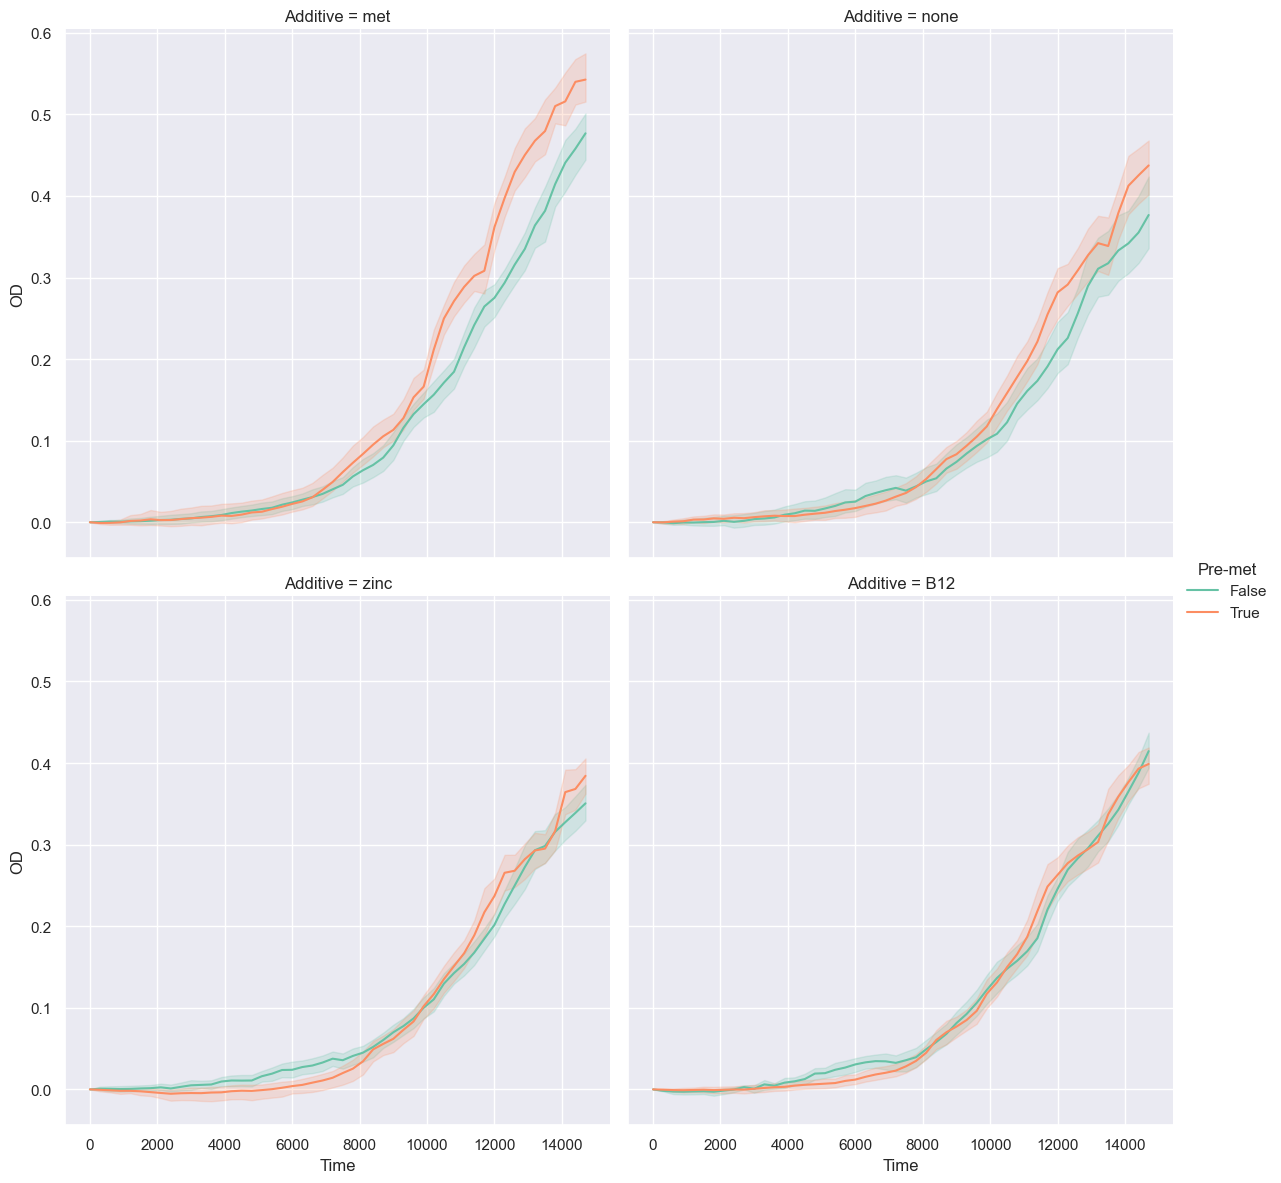

In [55]:
sns.relplot(x="Time", y="OD", kind="line", col="Additive", hue="Pre-met", height=6, col_wrap=2, data=mdf.filter(pl.col("Time")<15000))

In [56]:
meta = pl.read_csv("growth_data/adrian_growth_jan25_indicator.csv")
meta = meta.melt(id_vars='row', variable_name="col", value_name="experiment")
meta = meta.drop_nulls()
meta

shape: (64, 3)
┌─────┬─────┬────────────┐
│ row ┆ col ┆ experiment │
│ --- ┆ --- ┆ ---        │
│ str ┆ str ┆ str        │
╞═════╪═════╪════════════╡
│ A   ┆ 2   ┆ Rrm1       │
│ B   ┆ 2   ┆ Rr1        │
│ C   ┆ 2   ┆ RrZ1       │
│ D   ┆ 2   ┆ Rrb1       │
│ E   ┆ 2   ┆ rm1        │
│ …   ┆ …   ┆ …          │
│ D   ┆ 9   ┆ Rrb8       │
│ E   ┆ 9   ┆ rm8        │
│ F   ┆ 9   ┆ r8         │
│ G   ┆ 9   ┆ rz8        │
│ H   ┆ 9   ┆ rb8        │
└─────┴─────┴────────────┘

In [57]:
df = pd.read_csv("growth_data/adrian_growth_jan25_v2.csv")
df = df.drop(['T∞ 600'], axis=1)
df["Time"] = pd.to_datetime(df['Time'],format= '%H:%M:%S', coerce=).dt.time

SyntaxError: invalid syntax (2494968700.py, line 3)

In [ ]:
pd.to_datetime(df['Time'],format= '%H:%M:%S').dt.time

In [ ]:
df = pd.read_csv("growth_data/adrian_growth_jan24.csv")
df = df.dropna()
df

In [ ]:
df = df.loc[:, ["Series1", "Series2", "Series3", "Series4", "Series5", "Series6", "Time_seconds", "ID"]]

In [ ]:
df = df.melt(id_vars=["Time_seconds", "ID"], var_name="Series", value_name="OD")
df = df.rename(columns={"Time_seconds": "Time", "ID": "Experiment"})

for k, v in {"RM": "+met", "RZ": "+Zn", "RB": "+B12", "R": "-met", }.items():
    df["Experiment"] = df["Experiment"].str.replace(k, v)

df

In [ ]:
df_truncated = df.copy()

df_truncated.loc[df_truncated["Experiment"].isin(["+B12", "+Zn"]), "Time"] = \
df_truncated.loc[df_truncated["Experiment"].isin(["+B12", "+Zn"]), "Time"] +1100


df_truncated = df_truncated.loc[df_truncated["Time"].between(7500, 100000), :]


sns.relplot(x="Time", y="OD", hue="Experiment", kind="line", data=df_truncated, height=8)

In [ ]:
df_truncated = df.copy()

df_truncated.loc[df_truncated["Experiment"].isin(["+B12", "+Zn"]), "Time"] = df_truncated.loc[df_truncated["Experiment"].isin(["+B12", "+Zn"]), "Time"] +1000

df_truncated = df_truncated.loc[df_truncated["Time"].between(7500, 20000), :]



sns.relplot(x="Time", y="OD", hue="Experiment", style="Series", col="Experiment", kind="line", col_wrap=2, data=df_truncated, height=4
        )